# BE - Benign Equivalized

In [1]:
import numpy as np
from numpy import genfromtxt, argmax
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"  
import pandas as pd
import re
import gc
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score, precision_score, recall_score, mean_absolute_error, matthews_corrcoef, roc_curve, auc,RocCurveDisplay

import tensorflow as tf
from keras import regularizers
from keras.models import Sequential, load_model
from keras.optimizers import Adam
from keras.layers import Dense, Dropout, Activation, GaussianNoise
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

pd.set_option('display.max_columns', None)
plt.rcParams["figure.figsize"] = (27, 10)
# plt.rcParams["xtick.labelsize"] = 10
sns.set_context('paper', font_scale=2)

In [2]:
def calculate_classifications(y_p, y, a): #calculate correct and wrong classifications by attack category
    y_p = y_p.flatten()
    df= pd.DataFrame({'pred':y_p, 'label':y, 'attack':a})
    df['misclassification'] = df.apply(f, axis=1)
    df = df[df['attack']!='Benign']
    attacks = df['attack'].unique()
    att_dic_w = dict((n, 0) for n in attacks)
    att_dic_c = att_dic_w.copy()
    count_series = df.groupby(['attack', 'misclassification']).size()
    print(count_series)
    for key in attacks:
        counts = count_series.get(key).to_list()
        print(counts)
        if count_series.get(key).get(0) == None:
            counts.insert(0,0)
        elif count_series.get(key).get(1) == None:
            counts.insert(1,0)
        att_dic_w[key] = counts[1]
        att_dic_c[key] = counts[0]
    return att_dic_w, att_dic_c

def plot_roc_auc(y_true_oboa, y_true_rboa, y_pred_oboa, y_pred_rboa):
    ns_probs = [0 for _ in range(len(y_true_oboa))]
    
    #calculate fpr, tpr & thesholds for oboa, rboa, random
    fpr_oboa, tpr_oboa, thresholds_oboa = roc_curve(y_true_oboa, y_pred_oboa)
    fpr_rboa, tpr_rboa, thresholds_rboa = roc_curve(y_true_rboa, y_pred_rboa)
    fpr_rand, tpr_rand, thresholds_rand = roc_curve(y_true_oboa, ns_probs)
    
    #auc calculation
    auc_oboa = auc(fpr_oboa, tpr_oboa)    
    auc_rboa = auc(fpr_rboa, tpr_rboa)
    auc_rand = auc(fpr_rand, tpr_rand)
    print('OBOA: ROC AUC=%.3f' % (auc_oboa))
    print('RBOA: ROC AUC=%.3f' % (auc_rboa))
    print('Random: ROC AUC=%.3f' % (auc_rand))
    
    #plot data
    plt.plot(fpr_oboa, tpr_oboa, marker='.', label='OBOA')
    plt.plot(fpr_rboa, tpr_rboa, marker='.', label='RBOA')
    plt.plot(fpr_rand, tpr_rand, linestyle='--', label='0.5')    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

def plot_attack_classifications(att_dic_w, att_dic_c): #plot correct and wrong classifications by attack category
    width = 0.4
    keys = att_dic_w.keys()
    values_w = att_dic_w.values()
    values_c = att_dic_c.values()
    x = np.arange(len(keys))
    fig, ax = plt.subplots()
    r1 = ax.bar(x - width/2, values_w, width, label = "Misclassified")
    r2 = ax.bar(x + width/2, values_c, width, label = "Correct Classification")
    ax.set_ylabel('Count')
    ax.set_xlabel('Attack')
    ax.set_title('Classification by Attack')
    ax.set_xticks(x)
    ax.set_xticklabels(keys)
    ax.legend()
    ax.bar_label(r1, padding=3)
    ax.bar_label(r2, padding=3)
    plt.xticks(rotation=45, ha='right')
    fig.tight_layout()
#     plt.rcParams["figure.figsize"] = (30, 10)
#     plt.rcParams["xtick.labelsize"] = 10
    plt.show()
    
#https://stackoverflow.com/questions/42528921/how-to-prevent-overlapping-x-axis-labels-in-sns-countplot
def attack_report(y, y_p, a):
    att_dic_w, att_dic_c = calculate_classifications(y_p, y, a)
    plot_attack_classifications(att_dic_w, att_dic_c)


def f(row):
    if row['pred'] != row['label']:
        val = 1
    else: val = 0
    return val
    
def print_cm(y_test,y_pred_round): #show confusion matrix
    cm = confusion_matrix(y_test,y_pred_round)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Anomaly'])
    disp = disp.plot(include_values=True, cmap = 'Blues')
    print(cm)
#     plt.rcParams["figure.figsize"] = (30, 10)
    plt.show()
    
def print_metrics(y_test,y_pred_round): #print basic metrics
    f1 = f1_score(y_test, y_pred_round, average='binary')
    acc = accuracy_score(y_test, y_pred_round)
    prec = precision_score(y_test, y_pred_round, average='binary')
    recall = recall_score(y_test, y_pred_round, average = 'binary')
    mcc = matthews_corrcoef(y_test, y_pred_round)
    print('accuracy: ',acc)
    print('f1: ', f1)
    print('precision: ', prec)
    print('recall: ', recall)
    print('mcc: ', mcc)
    
def training_report(train_model): #plot acc and loss vs epochs
    loss_vals = train_model.history['loss']
    epochs = range(1, len(loss_vals)+1)
#     plt.rcParams["figure.figsize"] = (30, 10)
    validation_loss = train_model.history['val_loss']
    plt.plot(epochs, loss_vals, label='Training Loss')
    plt.plot(epochs, validation_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    acc_vals = train_model.history['binary_accuracy']
    validation_acc = train_model.history['val_binary_accuracy']
    plt.plot(epochs, acc_vals, label='Training Accuracy')
    plt.plot(epochs, validation_acc, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
def test_report(y_test,y_pred_round):
    print_cm(y_test,y_pred_round)
    print_metrics(y_test,y_pred_round)

# Data Index

- X_train, y_train - Training data from 3 datasets 
- X_test, y_test - Test data from 3 datasets 
- X_val, y_val - Validation data from 3 datasets 
- X_1, y_1 - 1 datasets, test phase 2 data

In [3]:
folder_oboa = 'oboa\\'
name_tail_oboa = '_oboa'
folder_rboa = 'rboa\\'
name_tail_rboa = '_rboa'
dnnfolder = 'E1_DNN\\'

batch_sz = 128
epochsz = 100
lr = 1e-3
esp = 10
rlrp = 5

NNs = [[20, 15, 15, 8], [20, 15, 15, 15, 8], [60, 30]]

DNN_20_15_15_8_oboa.h5
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                180       
_________________________________________________________________
dropout (Dropout)            (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 15)                315       
_________________________________________________________________
dropout_1 (Dropout)          (None, 15)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 15)                240       
_________________________________________________________________
dropout_2 (Dropout)          (None, 15)                0         
_________________________________________________________________
dense_3 (Dense)              (Non

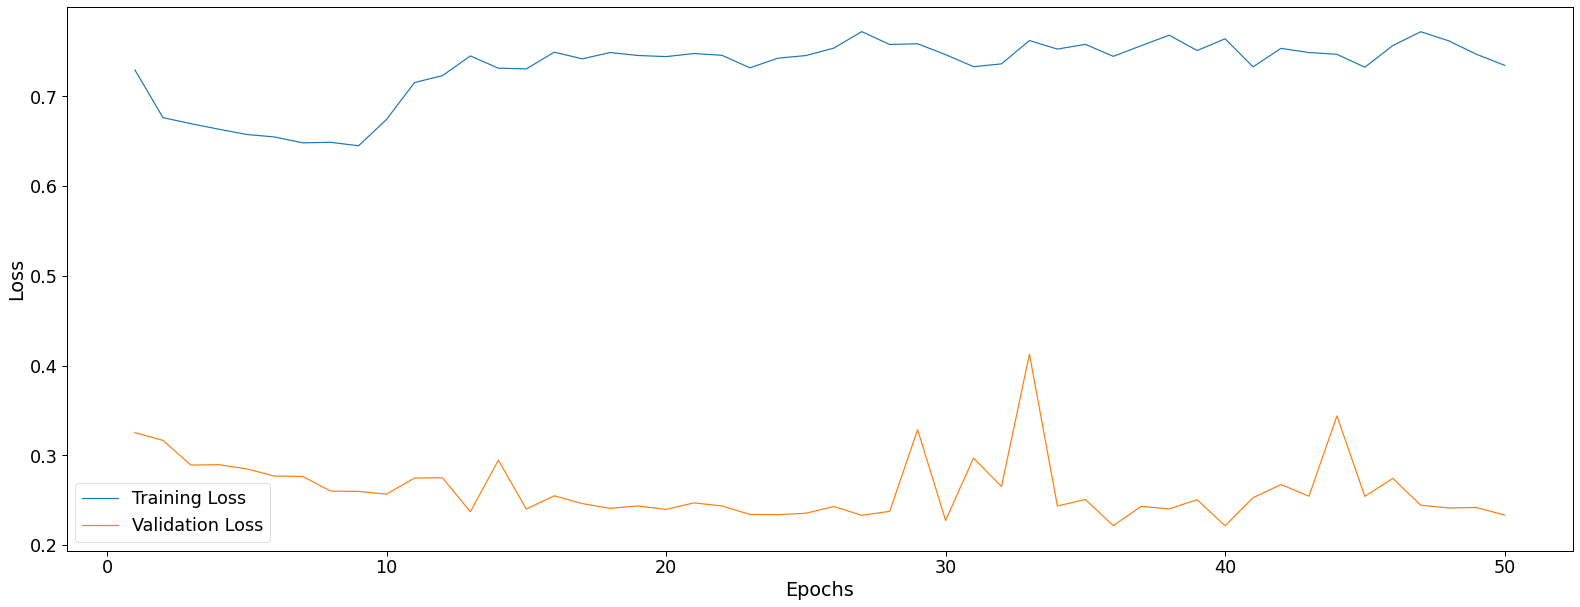

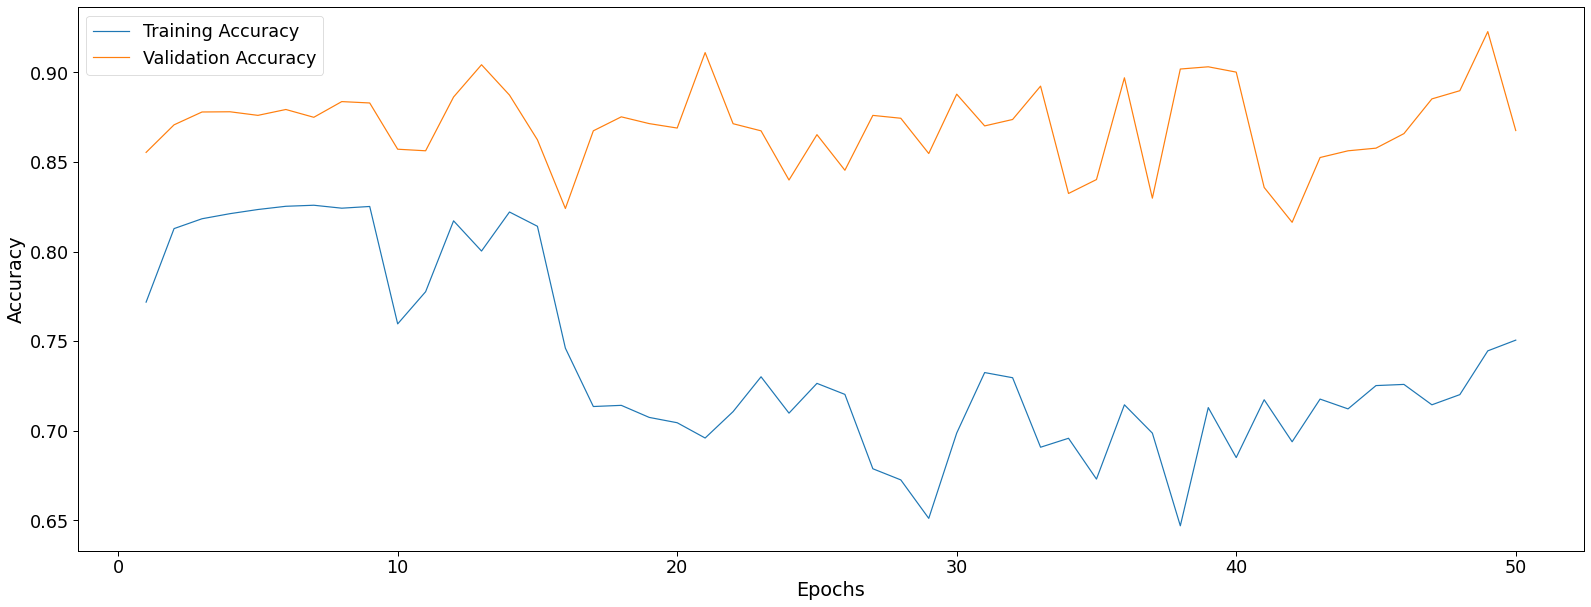

DNN_20_15_15_15_8_oboa.h5
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 20)                180       
_________________________________________________________________
dropout_4 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 15)                315       
_________________________________________________________________
dropout_5 (Dropout)          (None, 15)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 15)                240       
_________________________________________________________________
dropout_6 (Dropout)          (None, 15)                0         
_________________________________________________________________
dense_8 (Dense)             

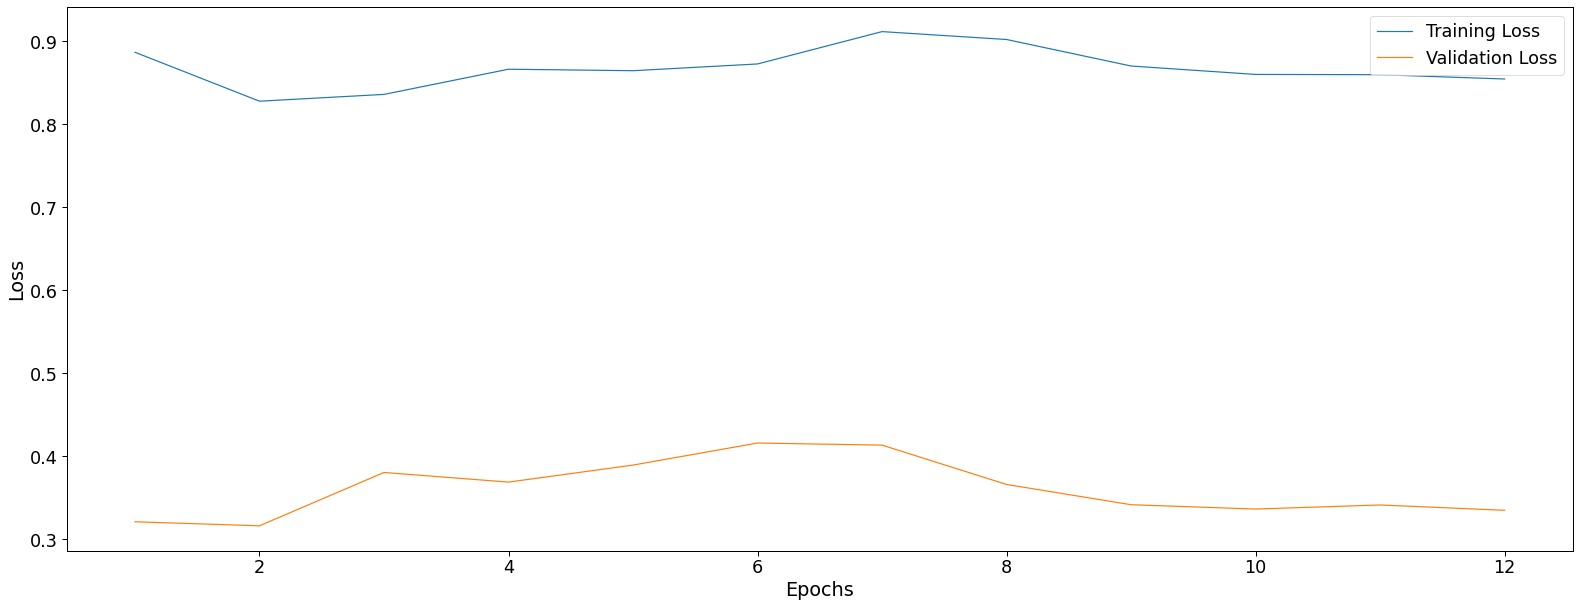

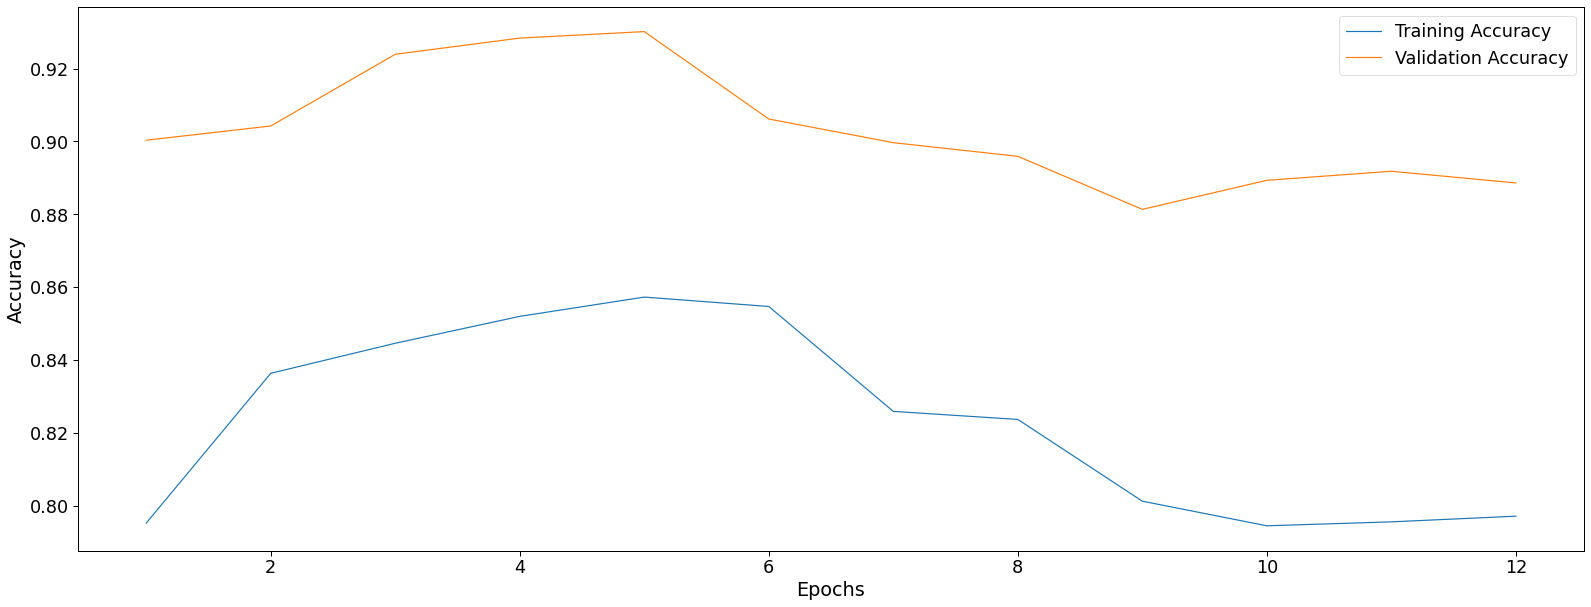

DNN_60_30_oboa.h5
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 60)                540       
_________________________________________________________________
dropout_9 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 30)                1830      
_________________________________________________________________
dropout_10 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 31        
Total params: 2,401
Trainable params: 2,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
56523/56523 [==============================] - 74s 1ms/step - loss: 0.4085 - binary_accu

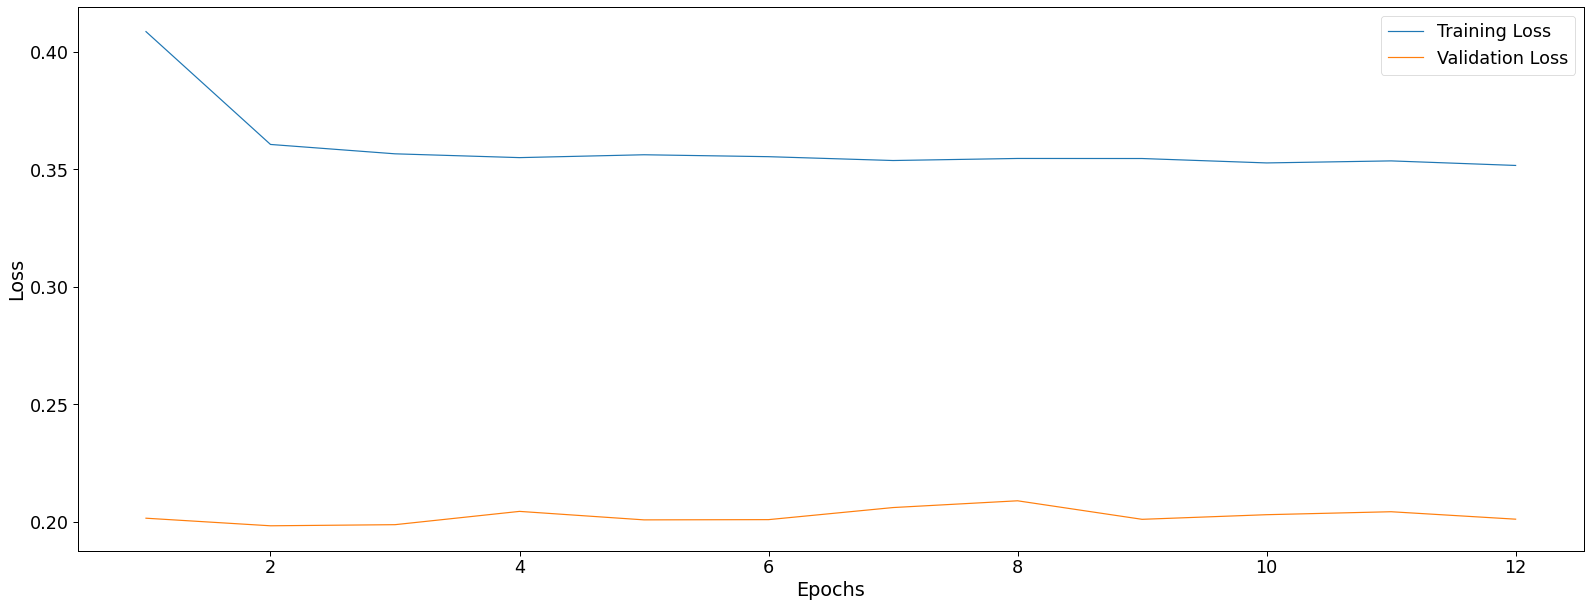

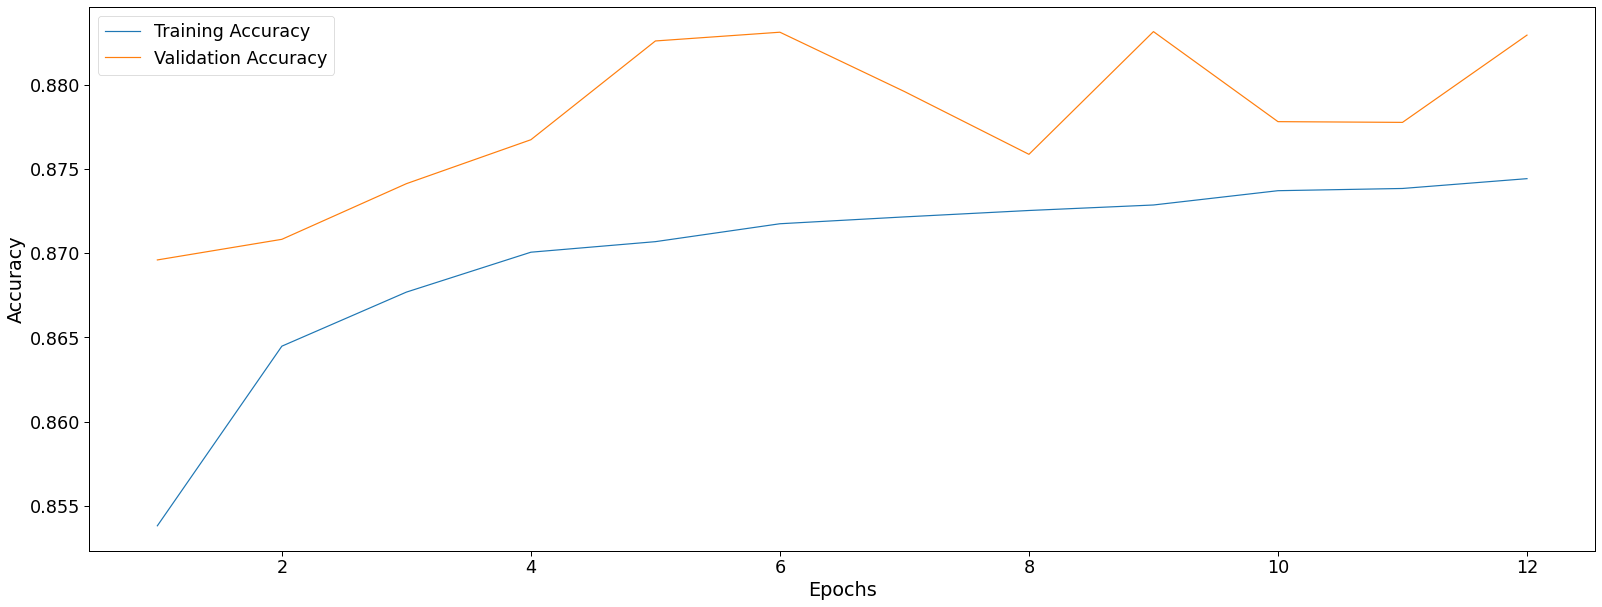

In [4]:
X_train = np.load(folder_oboa+'X_train.npy')
X_val = np.load(folder_oboa+'X_val.npy')
y_train = np.load(folder_oboa+'y_train.npy')
y_val = np.load(folder_oboa+'y_val.npy')

for NN in range(0, len(NNs)):
    dnn_file = "DNN_"+'_'.join(str(v) for v in NNs[NN])+name_tail_oboa+".h5"
    print(dnn_file)
    
    weights = {0:1, 1:5}
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=rlrp, verbose=0, mode='auto', cooldown=1, min_lr=1e-9, min_delta=0.0001)
    es = EarlyStopping(monitor='val_loss', patience=esp, mode='auto', restore_best_weights=False, min_delta=0.0001)
    opt = Adam(learning_rate=lr)

    DNN = Sequential()
    for c in range(0,len(NNs[NN])):
        if c == 0:
            DNN.add(Dense(NNs[NN][0], input_dim=len(X_train[0]), activation='relu'))
            DNN.add(Dropout(0.5))
        else:
            DNN.add(Dense(NNs[NN][c], activation='relu'))
            DNN.add(Dropout(0.5))
    DNN.add(Dense(1, activation='sigmoid'))
    DNN.compile(optimizer=opt, loss = 'binary_crossentropy', metrics=['BinaryAccuracy', 'Precision', 'Recall', 'AUC'])
    DNN.summary()
    train_DNN = DNN.fit(X_train, y_train, epochs=epochsz, batch_size=batch_sz, validation_data=(X_val, y_val), class_weight=weights, shuffle=True, callbacks=[es])#reduce_lr
    DNN.save(dnnfolder+dnn_file)
    training_report(train_DNN)

DNN_20_15_15_8_rboa.h5
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 20)                180       
_________________________________________________________________
dropout_11 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 15)                315       
_________________________________________________________________
dropout_12 (Dropout)         (None, 15)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 15)                240       
_________________________________________________________________
dropout_13 (Dropout)         (None, 15)                0         
_________________________________________________________________
dense_17 (Dense)             (N

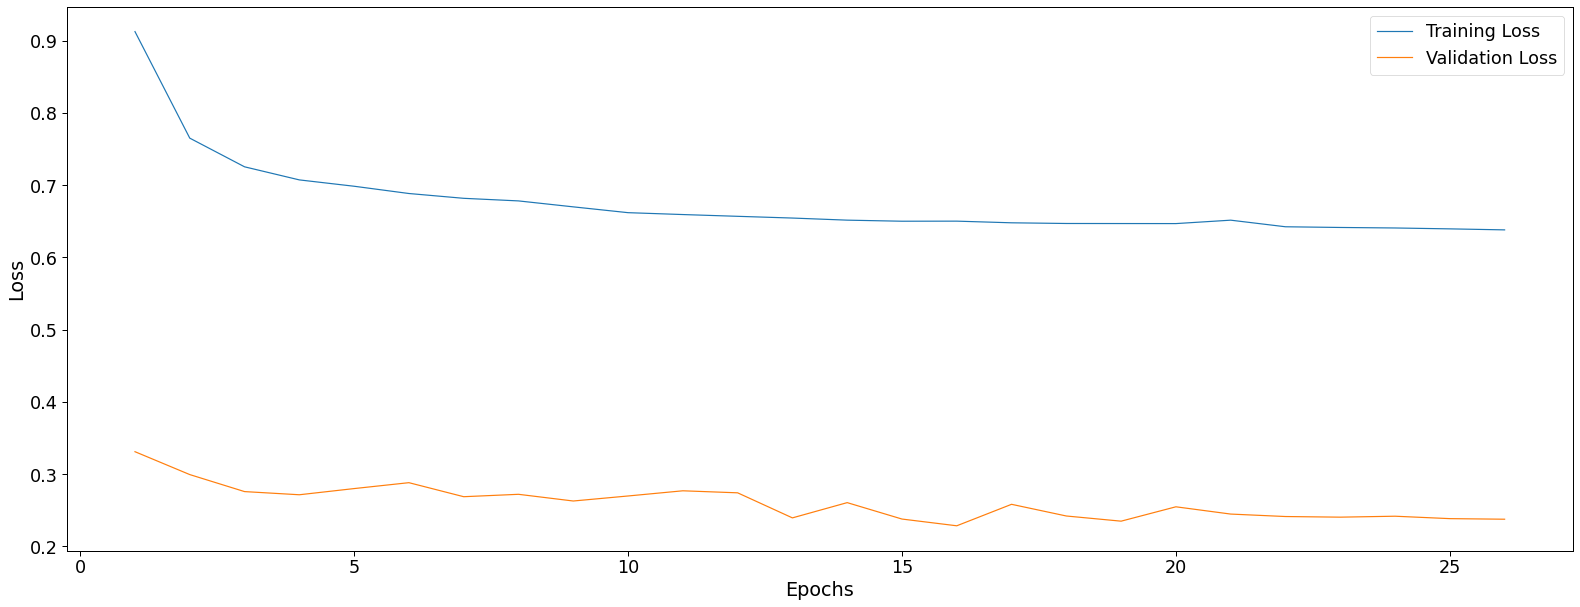

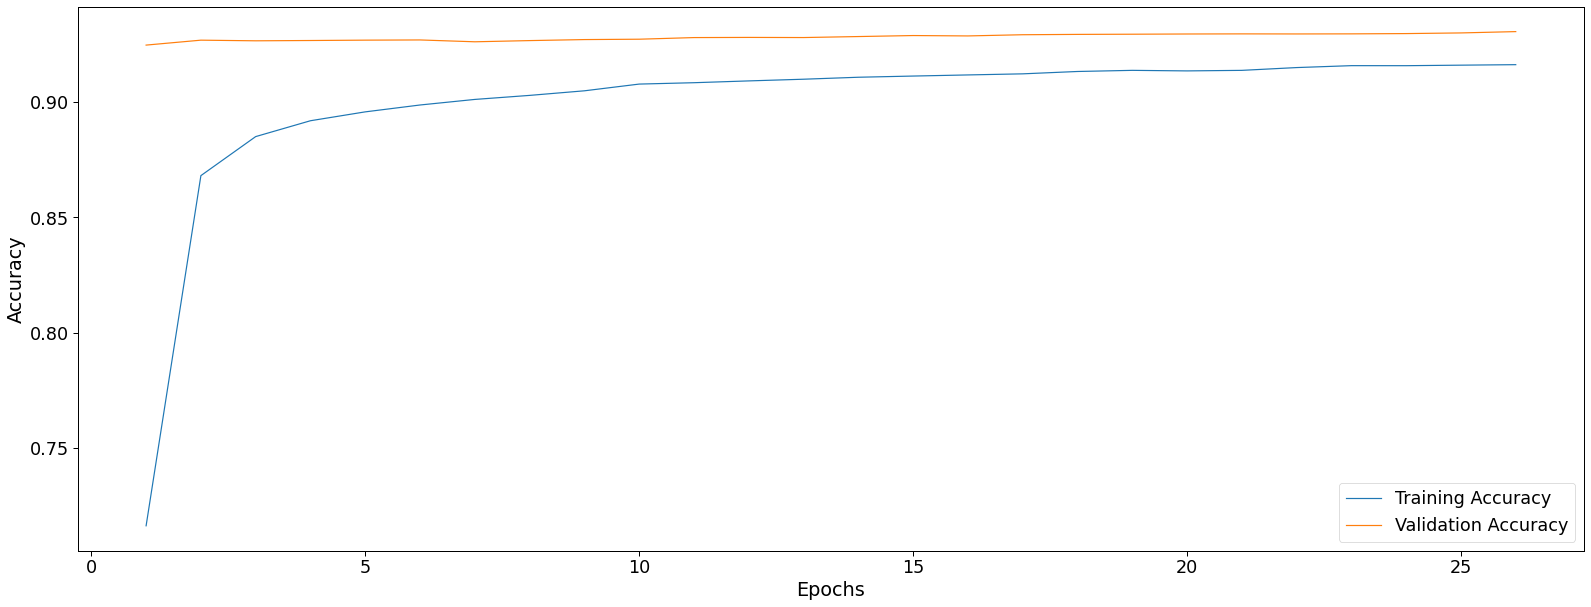

DNN_20_15_15_15_8_rboa.h5
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 20)                180       
_________________________________________________________________
dropout_15 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 15)                315       
_________________________________________________________________
dropout_16 (Dropout)         (None, 15)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 15)                240       
_________________________________________________________________
dropout_17 (Dropout)         (None, 15)                0         
_________________________________________________________________
dense_22 (Dense)            

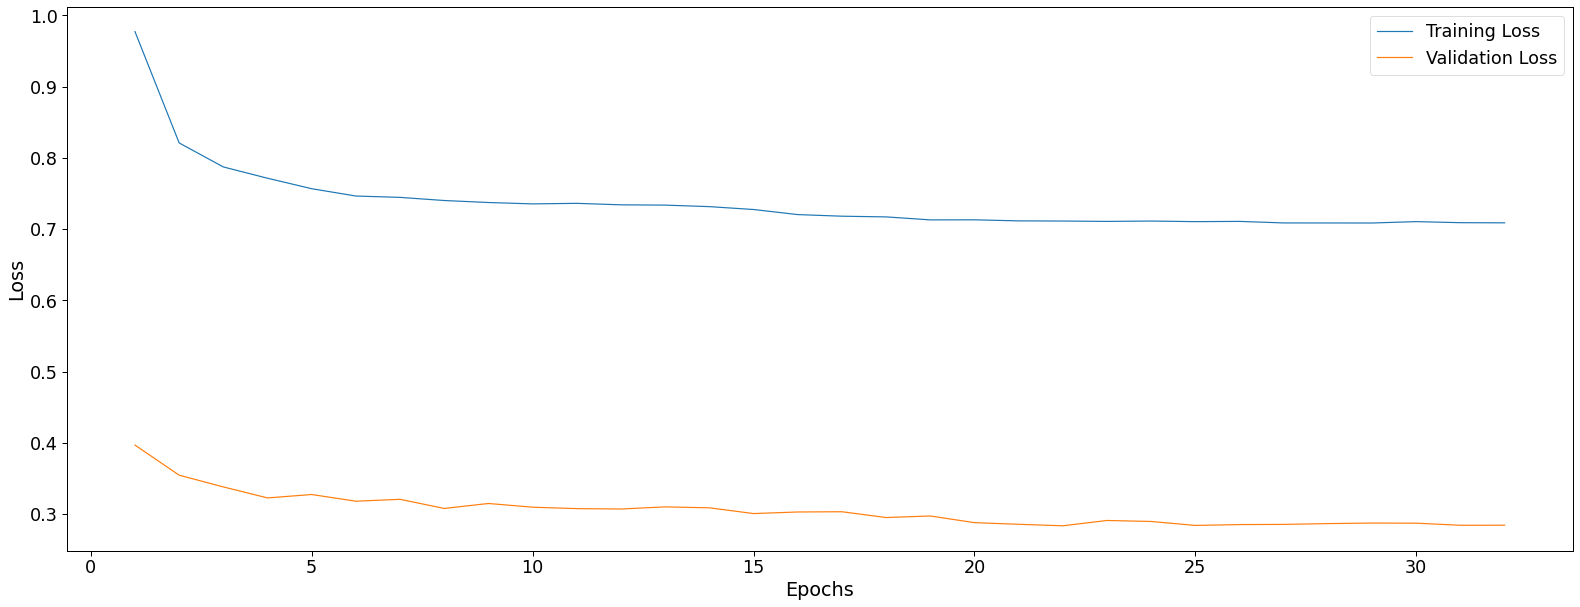

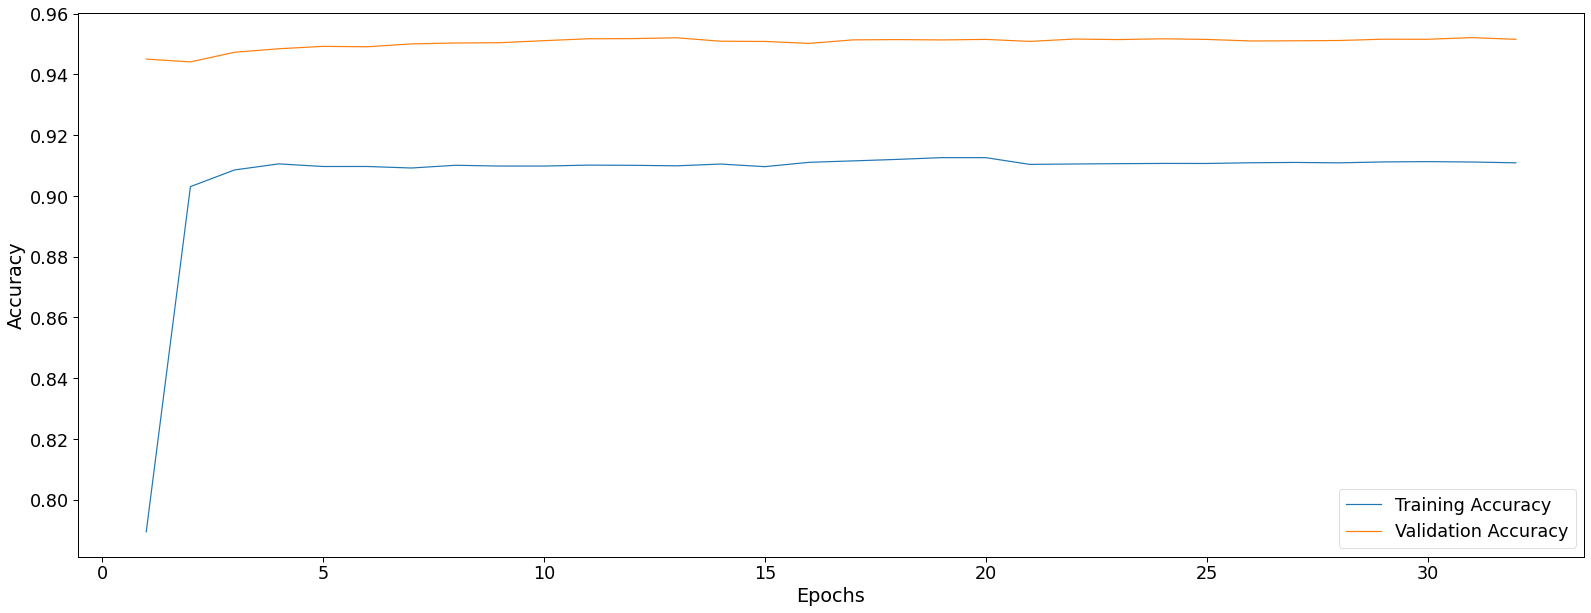

DNN_60_30_rboa.h5
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 60)                540       
_________________________________________________________________
dropout_20 (Dropout)         (None, 60)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 30)                1830      
_________________________________________________________________
dropout_21 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 31        
Total params: 2,401
Trainable params: 2,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
56523/56523 [==============================] - 74s 1ms/step - loss: 0.6078 - binary_accu

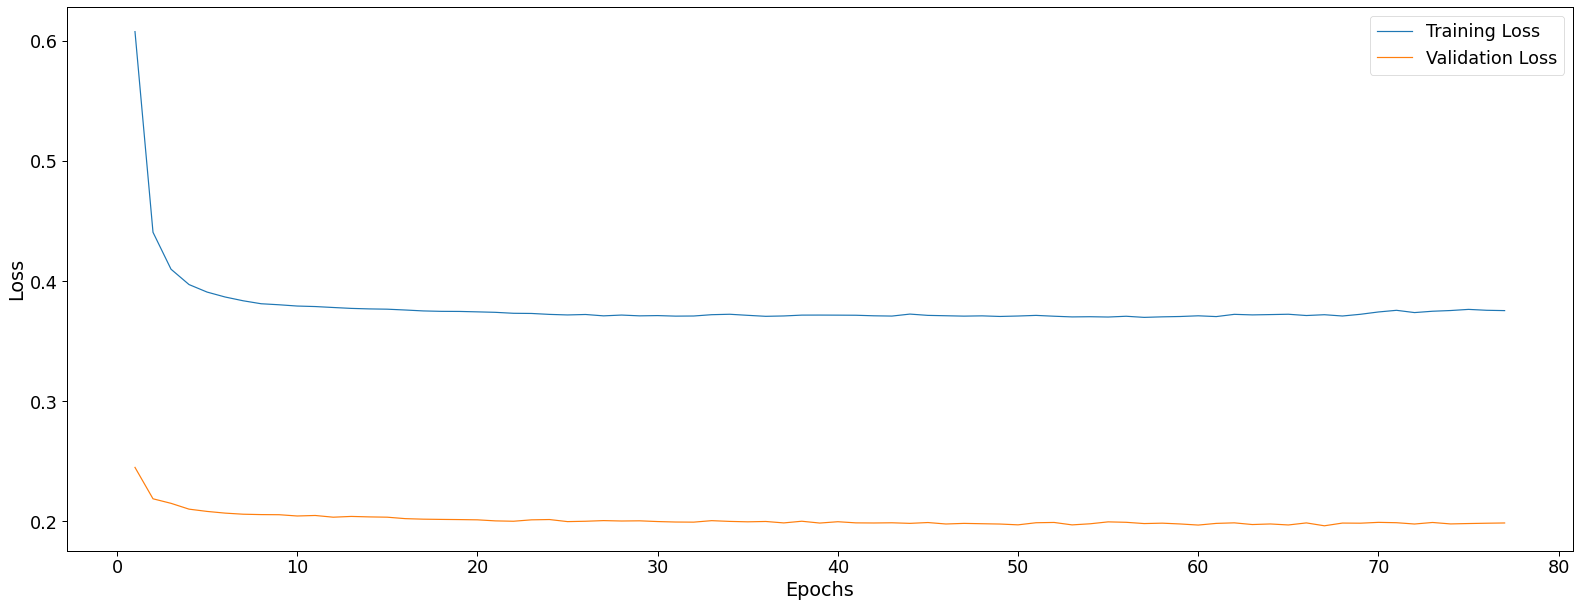

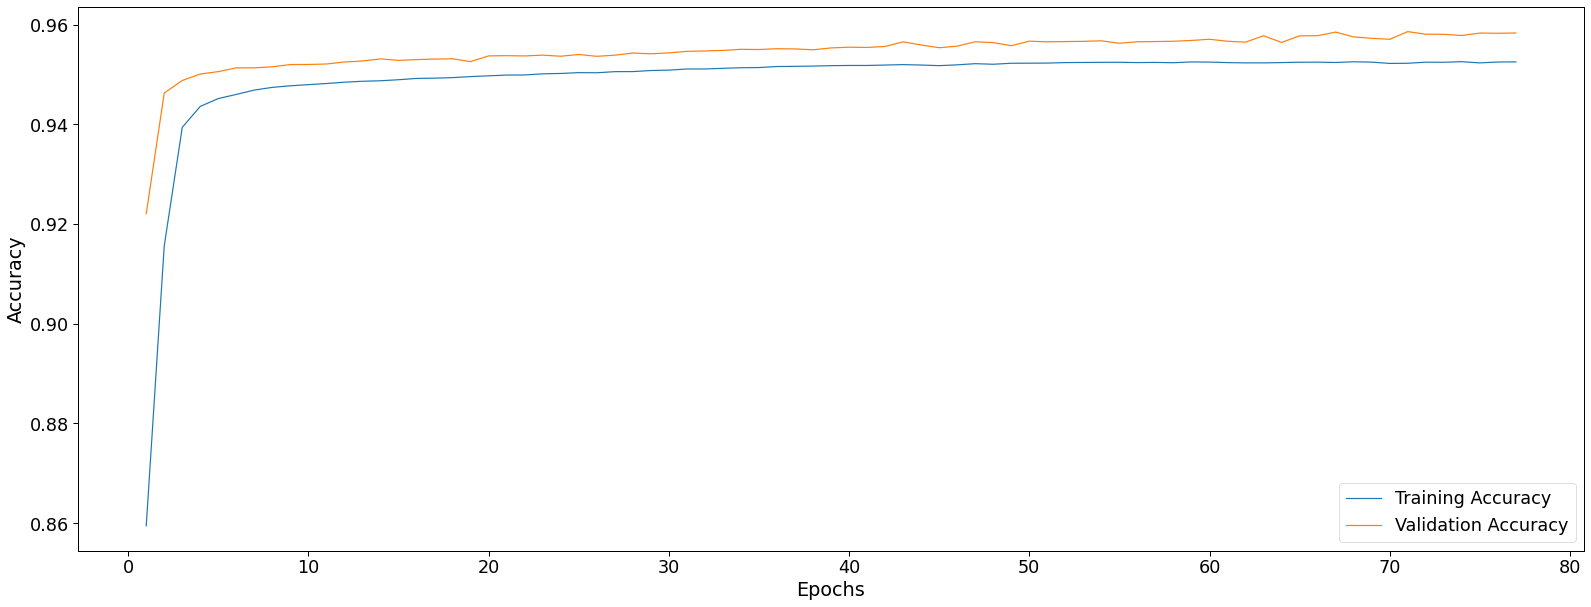

In [5]:
X_train = np.load(folder_rboa+'X_train.npy')
X_val = np.load(folder_rboa+'X_val.npy')
y_train = np.load(folder_rboa+'y_train.npy')
y_val = np.load(folder_rboa+'y_val.npy')

for NN in range(0, len(NNs)):

    dnn_file = "DNN_"+'_'.join(str(v) for v in NNs[NN])+name_tail_rboa+".h5"
    print(dnn_file)
    
    weights = {0:1, 1:5}
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=rlrp, verbose=0, mode='auto', cooldown=1, min_lr=1e-9, min_delta=0.0001)
    es = EarlyStopping(monitor='val_loss', patience=esp, mode='auto', restore_best_weights=False, min_delta=0.0001)
    opt = Adam(learning_rate=1e-4)

    DNN = Sequential()
    for c in range(0,len(NNs[NN])):
        if c == 0:
            DNN.add(Dense(NNs[NN][0], input_dim=len(X_train[0]), activation='relu'))
            DNN.add(Dropout(0.5))
        else:
            DNN.add(Dense(NNs[NN][c], activation='relu'))
            DNN.add(Dropout(0.5))
    DNN.add(Dense(1, activation='sigmoid'))
    DNN.compile(optimizer=opt, loss = 'binary_crossentropy', metrics=['BinaryAccuracy', 'Precision', 'Recall', 'AUC'])
    DNN.summary()
    train_DNN = DNN.fit(X_train, y_train, epochs=epochsz, batch_size=batch_sz, validation_data=(X_val, y_val), class_weight=weights, shuffle=True ,callbacks=[es])#reduce_lr
    DNN.save(dnnfolder+dnn_file)
    training_report(train_DNN)

# Test Set

-----------------------------------------


DNN_20_15_15_8_oboa.h5 

DNN_20_15_15_8_rboa.h5 

OBOA: ROC AUC=0.907
RBOA: ROC AUC=0.990
Random: ROC AUC=0.500


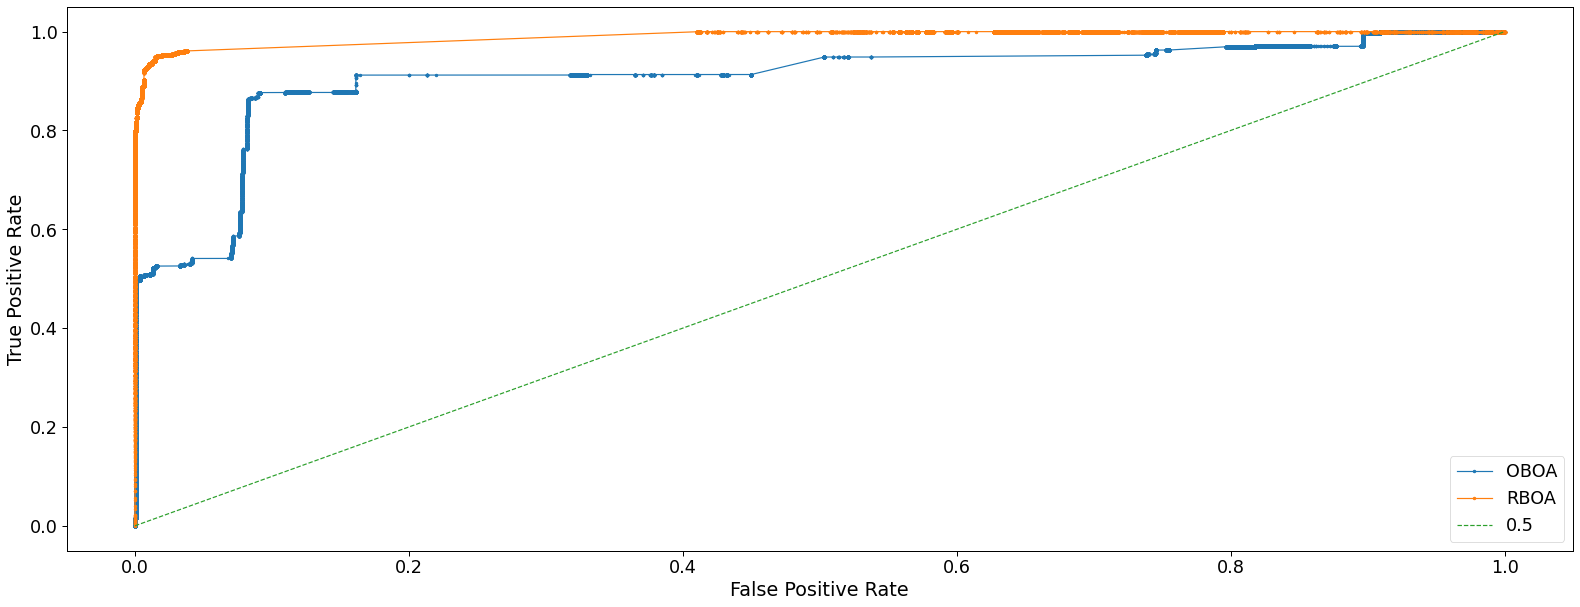

OBOA
[[ 500927 1414083]
 [  22951  455801]]


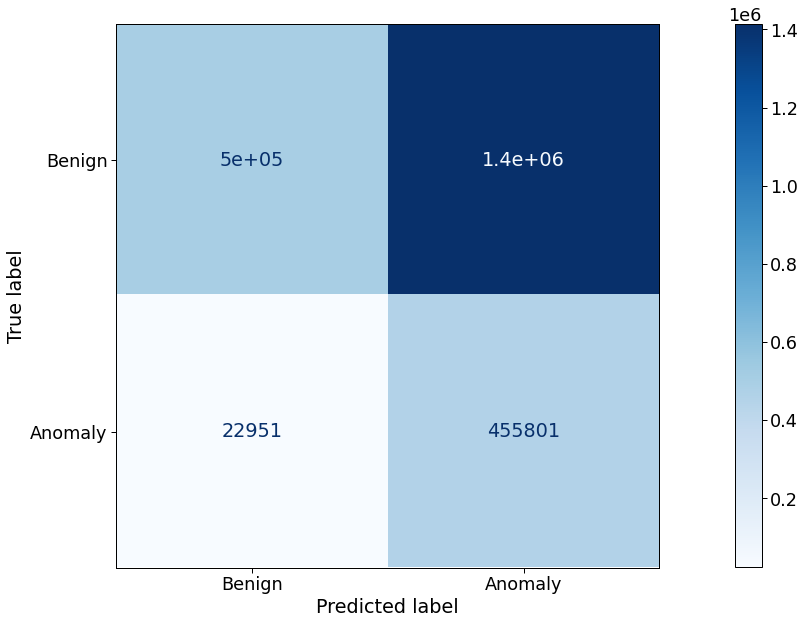

accuracy:  0.3996754898774398
f1:  0.388141031645602
precision:  0.2437589711447341
recall:  0.9520607746808368
mcc:  0.2066812873055872
RBOA
[[1842971   72037]
 [  18917  459835]]


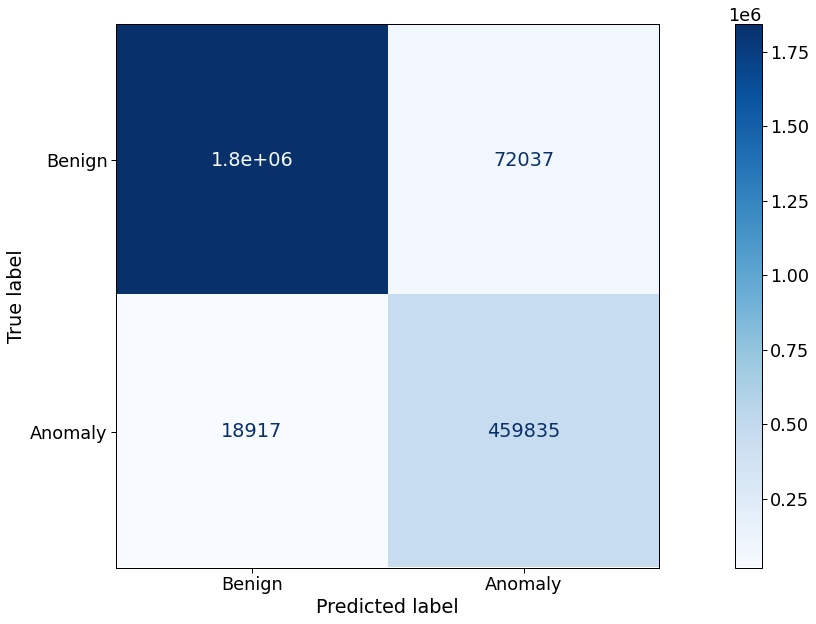

accuracy:  0.9620037096450772
f1:  0.910002137293395
precision:  0.8645595180795379
recall:  0.9604868491411002
mcc:  0.8879748769338912
-----------------------------------------


DNN_20_15_15_15_8_oboa.h5 

DNN_20_15_15_15_8_rboa.h5 

OBOA: ROC AUC=0.914
RBOA: ROC AUC=0.968
Random: ROC AUC=0.500


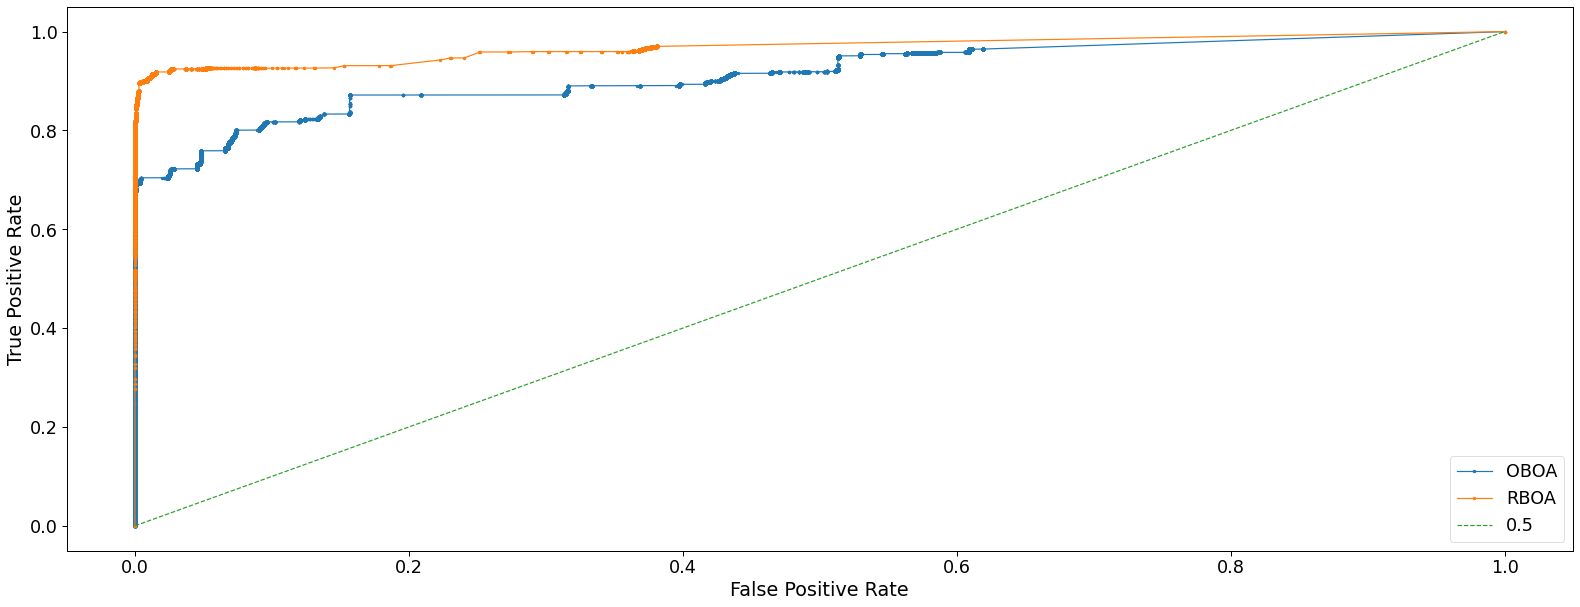

OBOA
[[1115801  799209]
 [  49201  429551]]


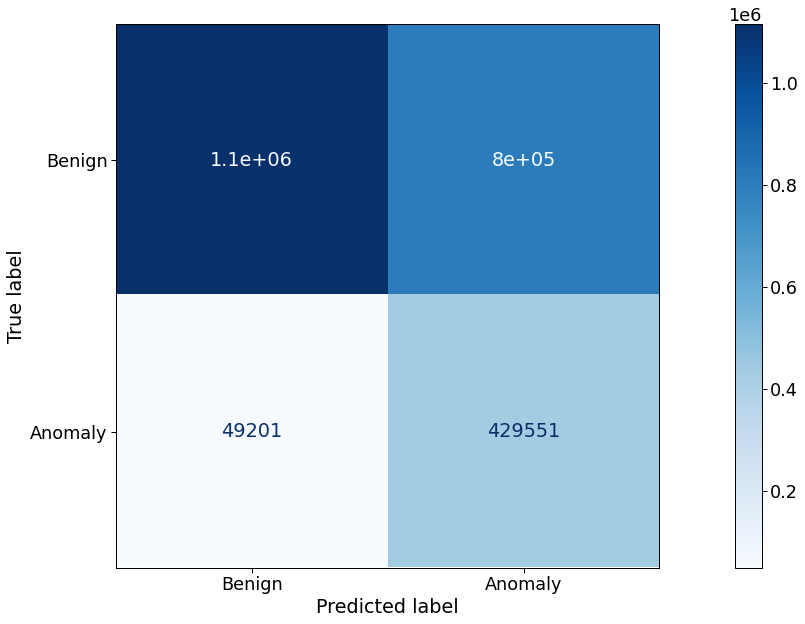

accuracy:  0.6455746227068522
f1:  0.5031308711154007
precision:  0.3495808782837983
recall:  0.8972307165296437
mcc:  0.3840492364346724
RBOA
[[1907835    7173]
 [  49439  429313]]


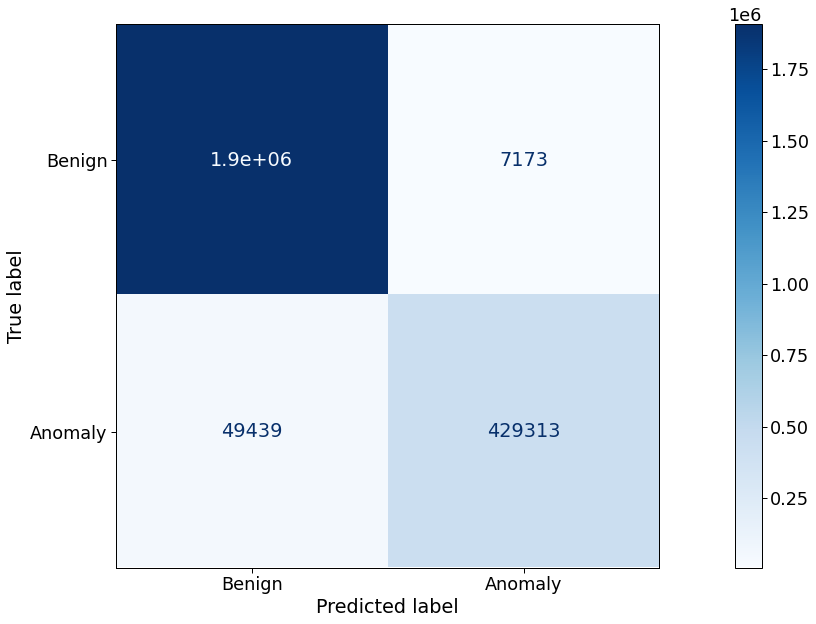

accuracy:  0.9763501771271974
f1:  0.9381450507955307
precision:  0.9835664832319937
recall:  0.8967335906690729
mcc:  0.9250712957670423
-----------------------------------------


DNN_60_30_oboa.h5 

DNN_60_30_rboa.h5 

OBOA: ROC AUC=0.954
RBOA: ROC AUC=0.989
Random: ROC AUC=0.500


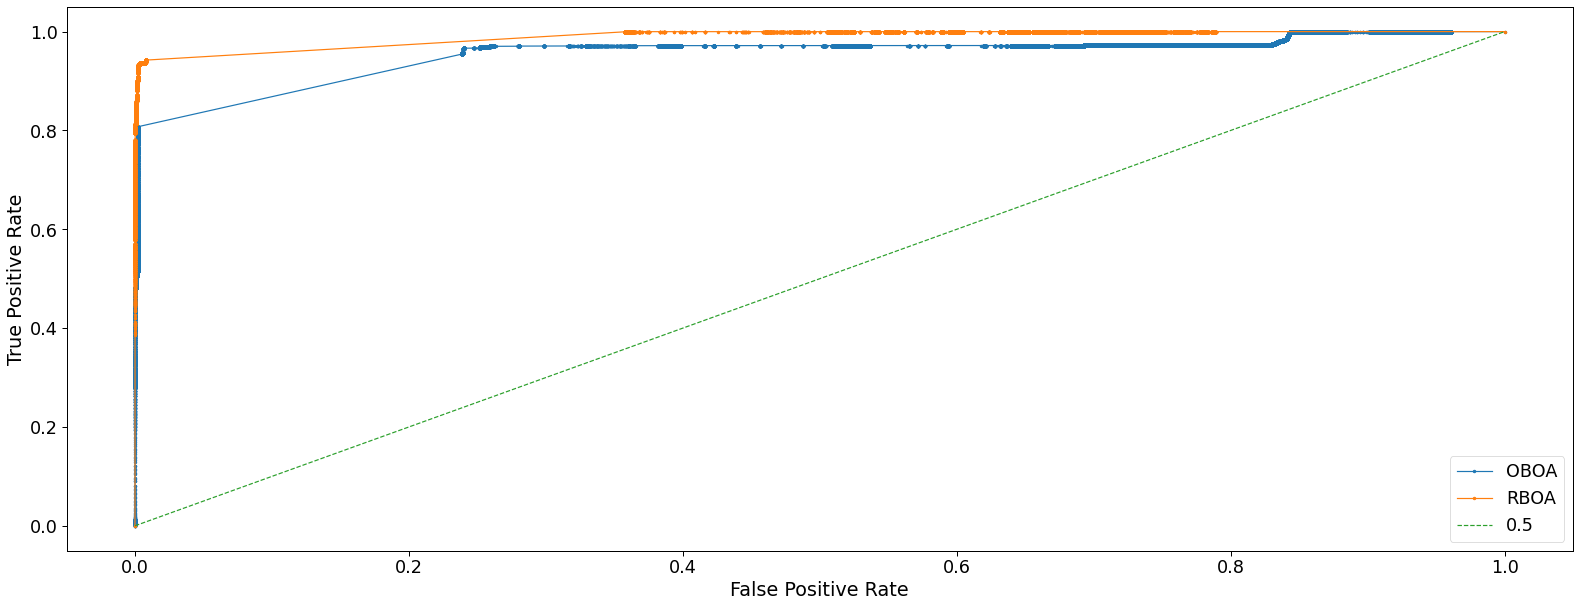

OBOA
[[1180786  734224]
 [  13610  465142]]


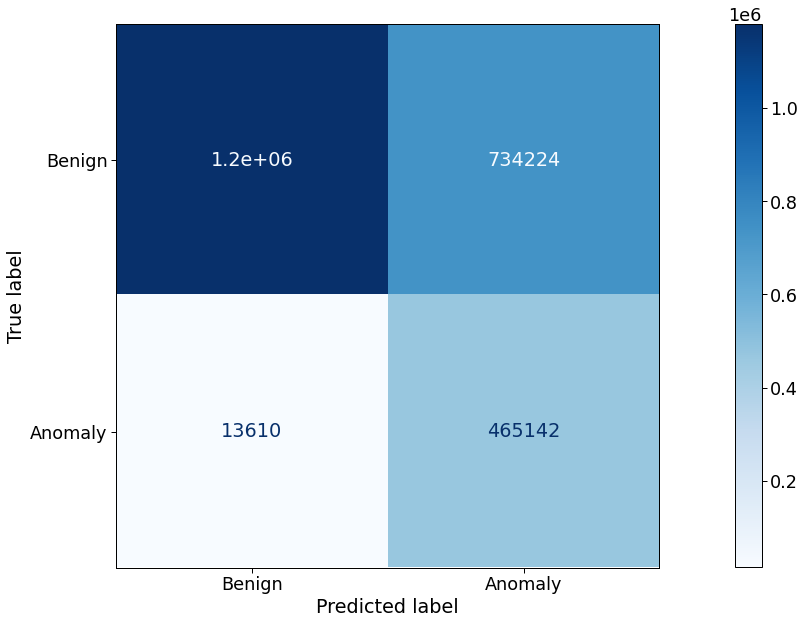

accuracy:  0.6875904956298914
f1:  0.5543614930535278
precision:  0.3878232332749136
recall:  0.9715719203261814
mcc:  0.47053457389241793
RBOA
[[1902233   12775]
 [  30156  448596]]


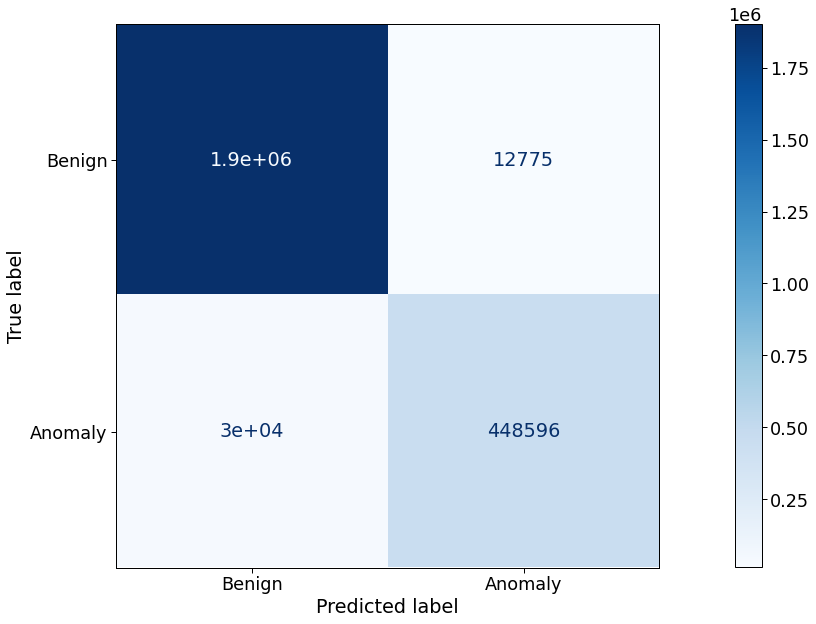

accuracy:  0.9820654535124658
f1:  0.9543346987575031
precision:  0.9723107867637975
recall:  0.9370112291959094
mcc:  0.9434306413968666


In [6]:
X_1_oboa = np.load(folder_oboa +'X_test.npy')
y_1_oboa = np.load(folder_oboa +'y_test.npy')

X_1_rboa = np.load(folder_rboa +'X_test.npy')
y_1_rboa = np.load(folder_rboa +'y_test.npy')

for NN in range(0, len(NNs)):
    print('-----------------------------------------\n\n')
    dnn_file_oboa = "DNN_"+'_'.join(str(v) for v in NNs[NN])+name_tail_oboa+".h5"
    dnn_file_rboa = "DNN_"+'_'.join(str(v) for v in NNs[NN])+name_tail_rboa+".h5"
    
    print(dnn_file_oboa, '\n')
    DNN = load_model(dnnfolder+dnn_file_oboa)
    y_pred_oboa = DNN.predict(X_1_oboa)
    y_predr_oboa = np.rint(y_pred_oboa)
    print(dnn_file_rboa, '\n')
    DNN = load_model(dnnfolder+dnn_file_rboa)
    y_pred_rboa = DNN.predict(X_1_rboa)
    y_predr_rboa = np.rint(y_pred_rboa)
    
    plot_roc_auc(y_1_oboa, y_1_rboa, y_pred_oboa, y_pred_rboa)
    
    print('OBOA')
    test_report(y_1_oboa ,y_predr_oboa)
    
    print('RBOA')
    test_report(y_1_rboa ,y_predr_rboa)
    

# AR Test Set (Benign Equalized)

-----------------------------------------


DNN_20_15_15_8_oboa.h5 

DNN_20_15_15_8_rboa.h5 

OBOA: ROC AUC=0.784
RBOA: ROC AUC=0.915
Random: ROC AUC=0.500


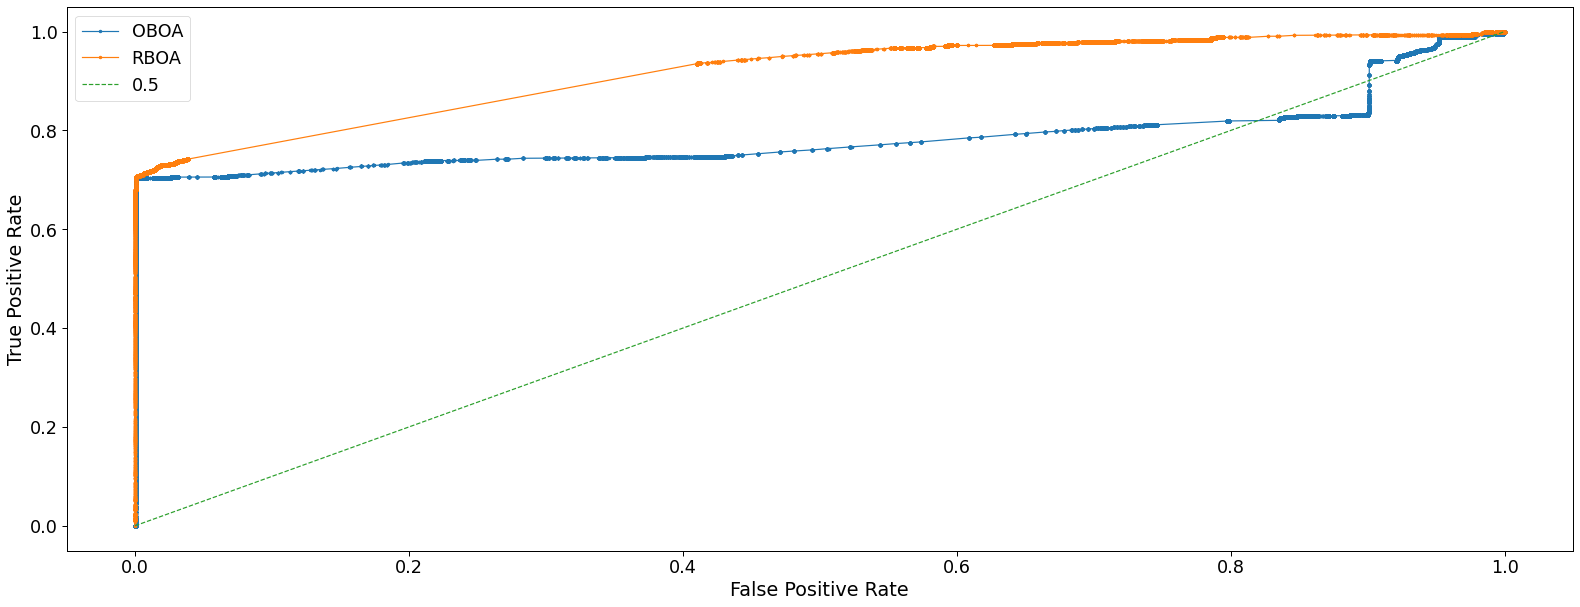

OBOA
[[1648676 8372173]
 [ 130144  594630]]


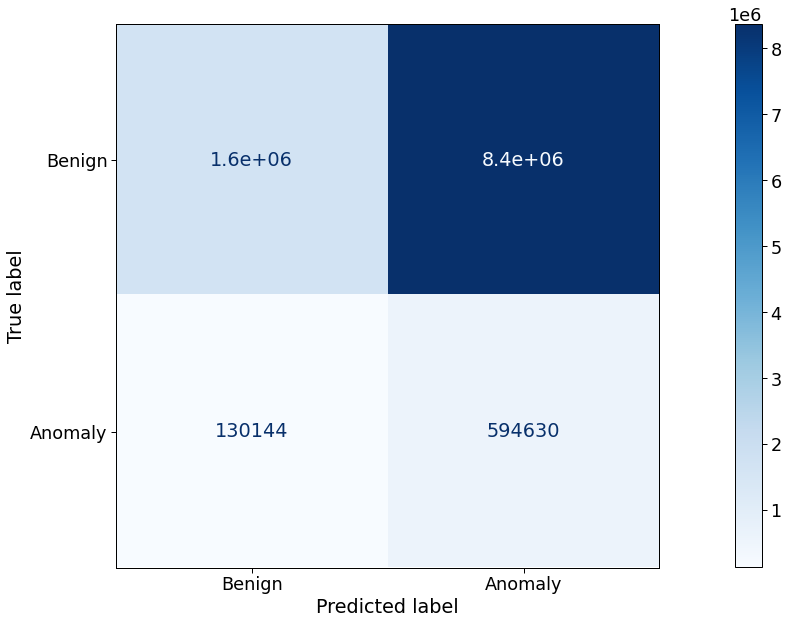

accuracy:  0.20876462909595841
f1:  0.1227106795932179
precision:  0.0663146051050748
recall:  0.8204350597565586
mcc:  -0.010149085383270669
attack                    misclassification
Brute Force -Web          0                       276
                          1                      1867
Brute Force -XSS          0                       120
                          1                       807
DoS attacks-GoldenEye     0                     27723
DoS attacks-Hulk          0                    432535
                          1                       113
DoS attacks-SlowHTTPTest  0                     14116
DoS attacks-Slowloris     0                      7284
                          1                      2228
FTP-BruteForce            0                     25933
Infilteration             0                     84415
                          1                     31946
SQL Injection             0                        60
                          1                       372
SSH-

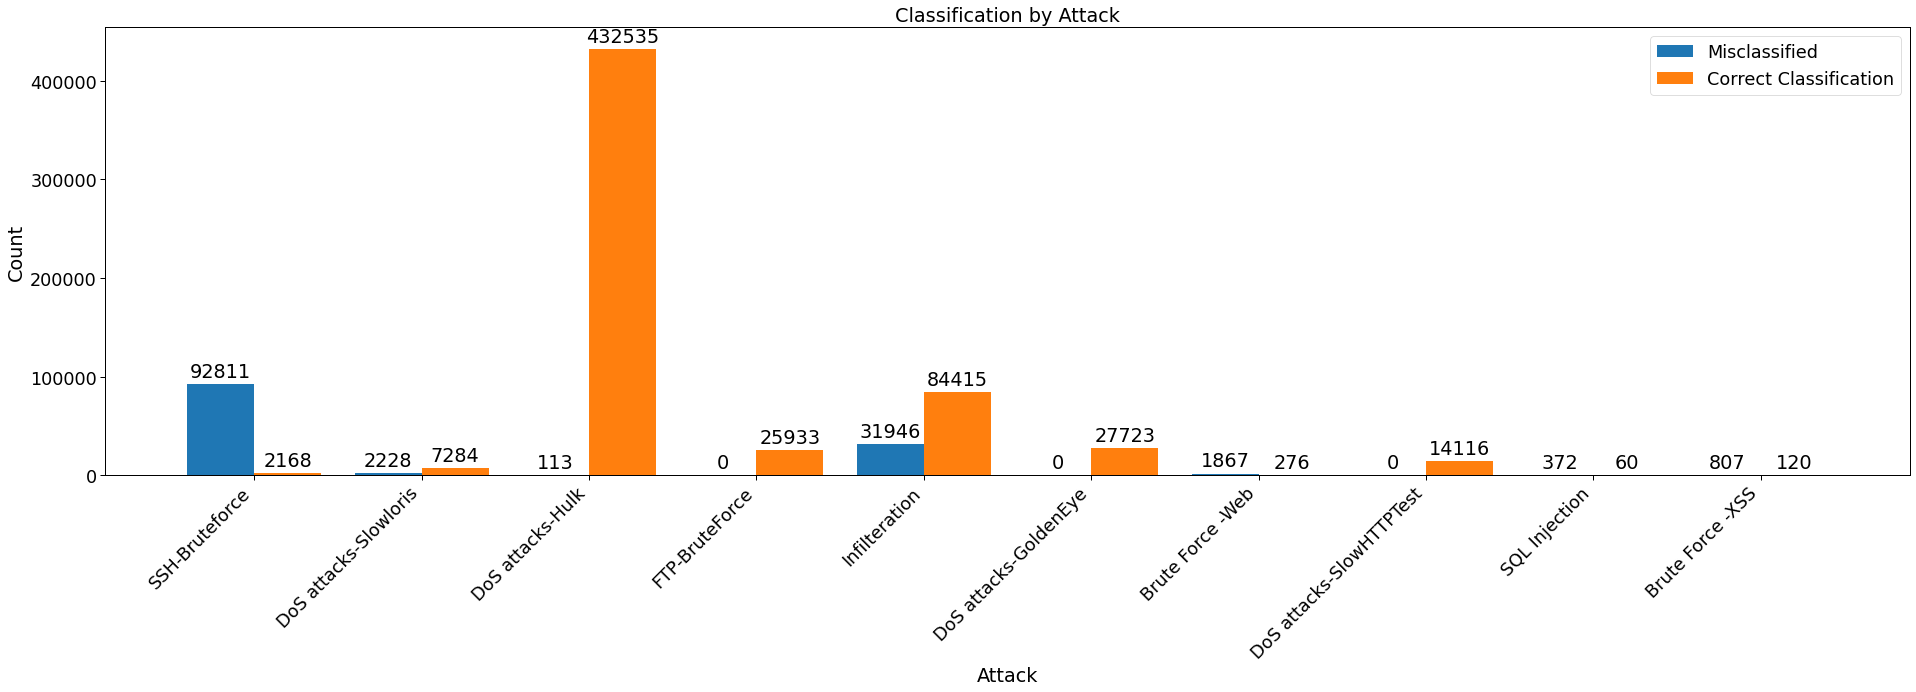

RBOA
[[9640724  380125]
 [ 187330  537444]]


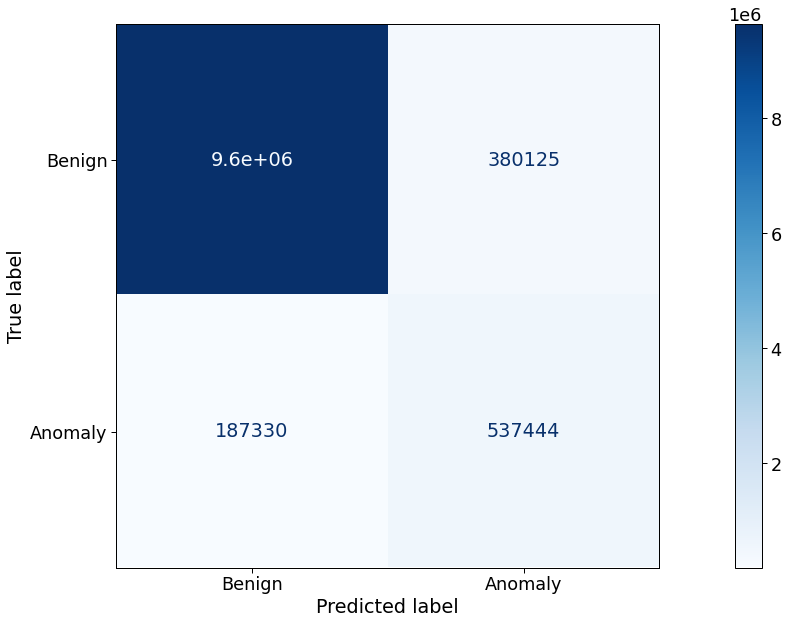

accuracy:  0.9471919869141138
f1:  0.6544844773594798
precision:  0.5857259781008295
recall:  0.7415332227701324
mcc:  0.6314313522887846
attack                    misclassification
Brute Force -Web          0                        50
                          1                      2093
Brute Force -XSS          0                        32
                          1                       895
DoS attacks-GoldenEye     0                     27723
DoS attacks-Hulk          0                    432648
DoS attacks-SlowHTTPTest  0                     14116
DoS attacks-Slowloris     0                      9512
FTP-BruteForce            0                     25933
Infilteration             0                     25262
                          1                     91099
SQL Injection             1                       432
SSH-Bruteforce            0                      2168
                          1                     92811
dtype: int64
[2168, 92811]
[9512]
[432648]
[25933]
[25262, 910

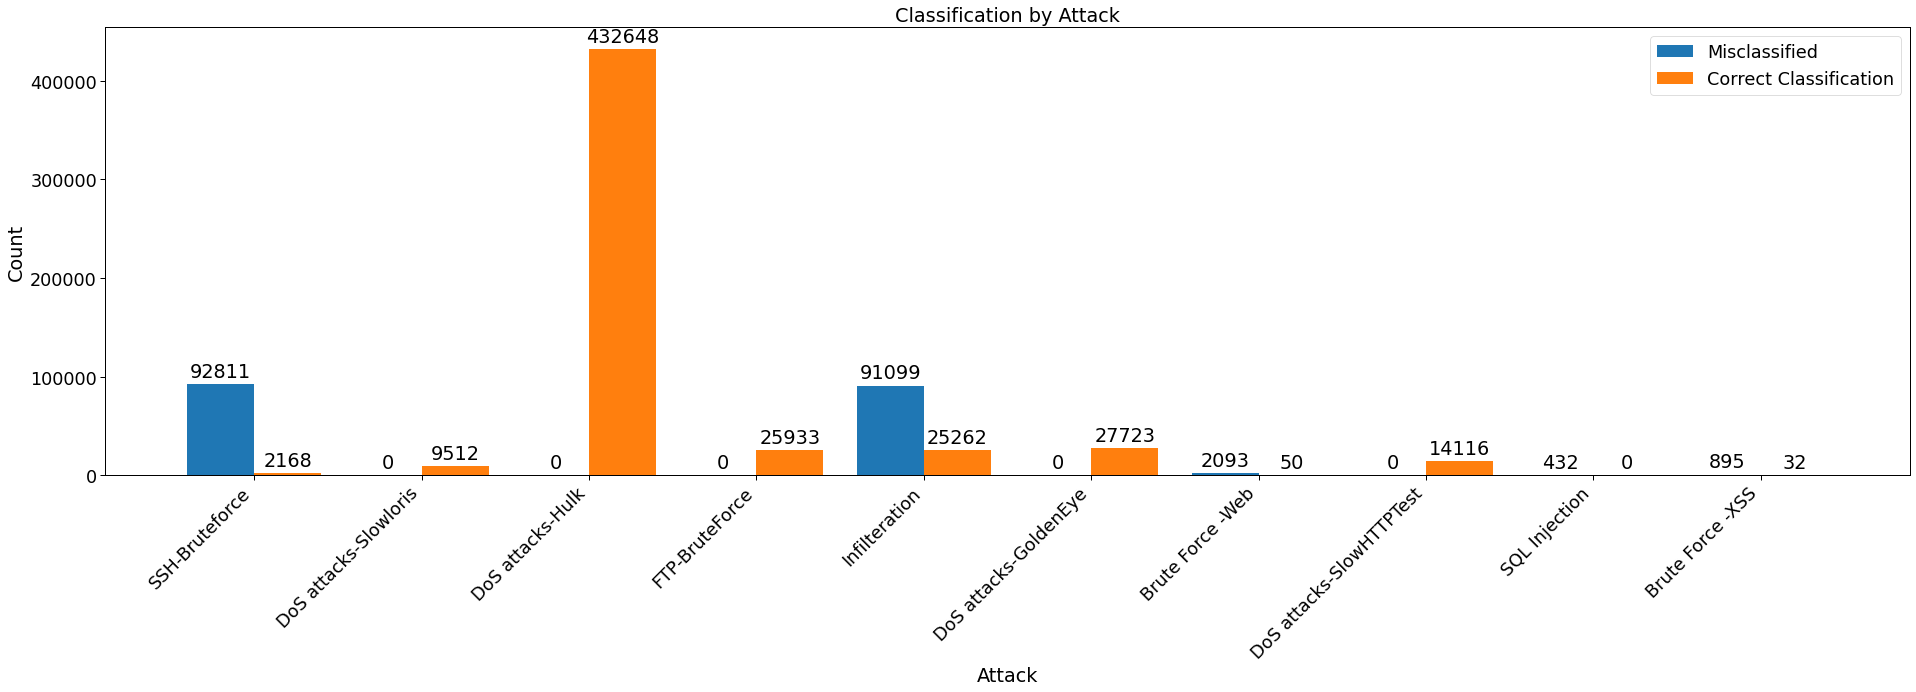

-----------------------------------------


DNN_20_15_15_15_8_oboa.h5 

DNN_20_15_15_15_8_rboa.h5 

OBOA: ROC AUC=0.823
RBOA: ROC AUC=0.856
Random: ROC AUC=0.500


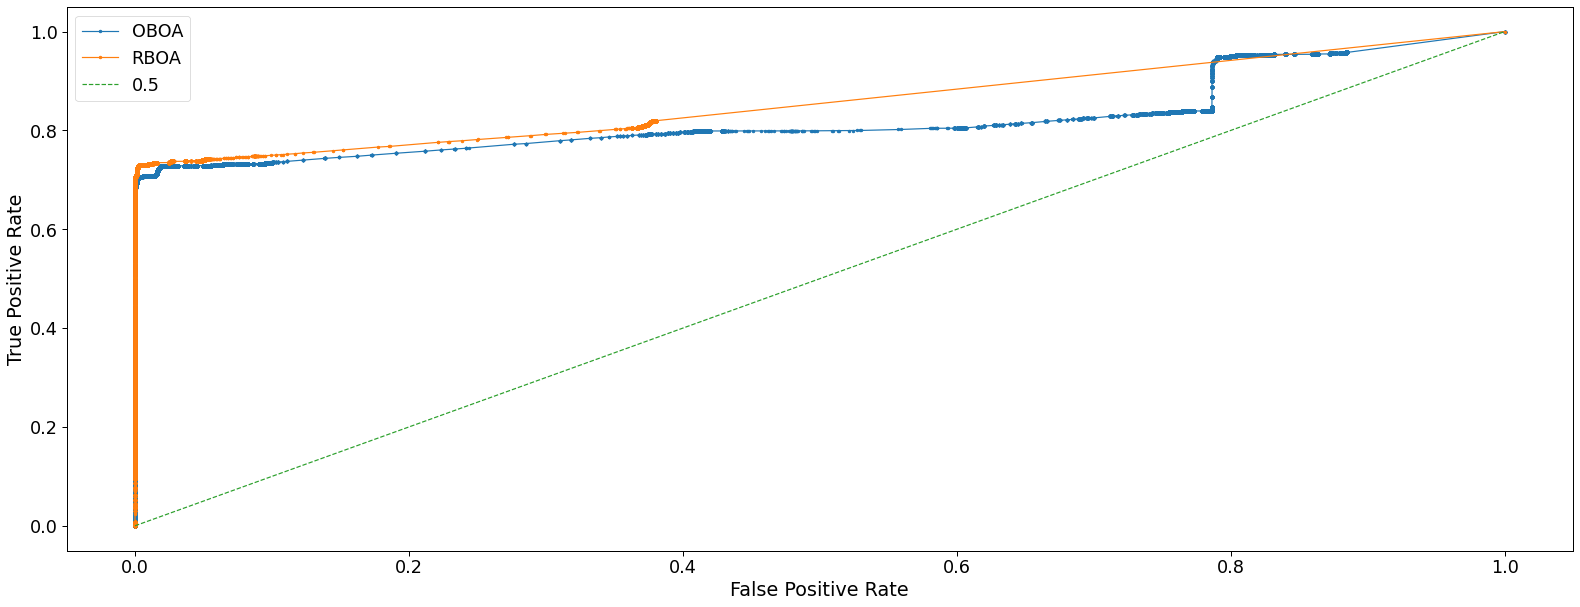

OBOA
[[2425694 7595155]
 [ 118579  606195]]


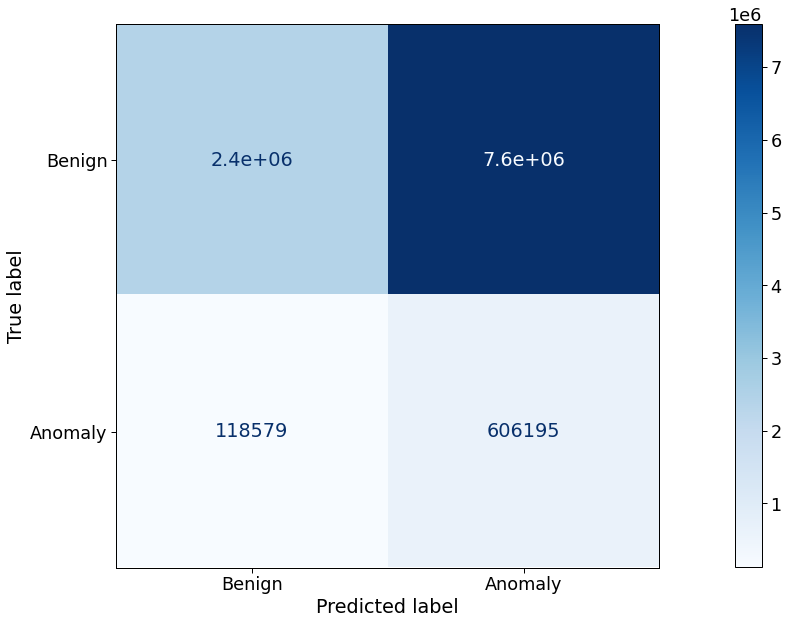

accuracy:  0.282151067462538
f1:  0.13582491123806928
precision:  0.07391405073554963
recall:  0.8363917579824883
mcc:  0.0462868725664985
attack                    misclassification
Brute Force -Web          0                        10
                          1                      2133
Brute Force -XSS          0                         6
                          1                       921
DoS attacks-GoldenEye     0                     27723
DoS attacks-Hulk          0                    432474
                          1                       174
DoS attacks-SlowHTTPTest  0                     14116
DoS attacks-Slowloris     0                      9512
FTP-BruteForce            0                     25933
Infilteration             0                     80166
                          1                     36195
SQL Injection             0                         3
                          1                       429
SSH-Bruteforce            0                     16252
       

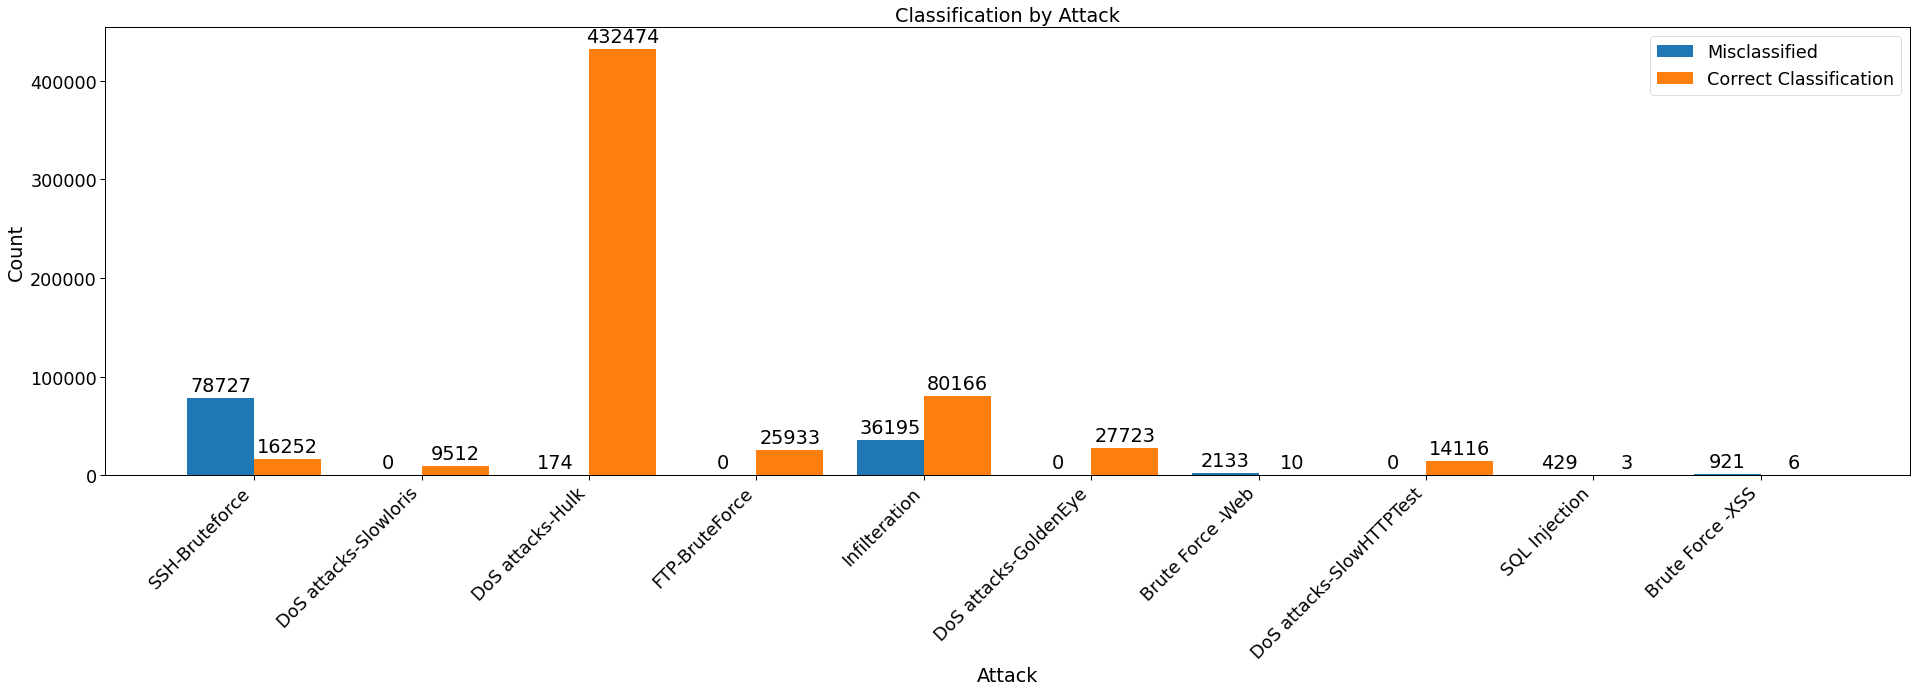

RBOA
[[9981538   39311]
 [ 196216  528558]]


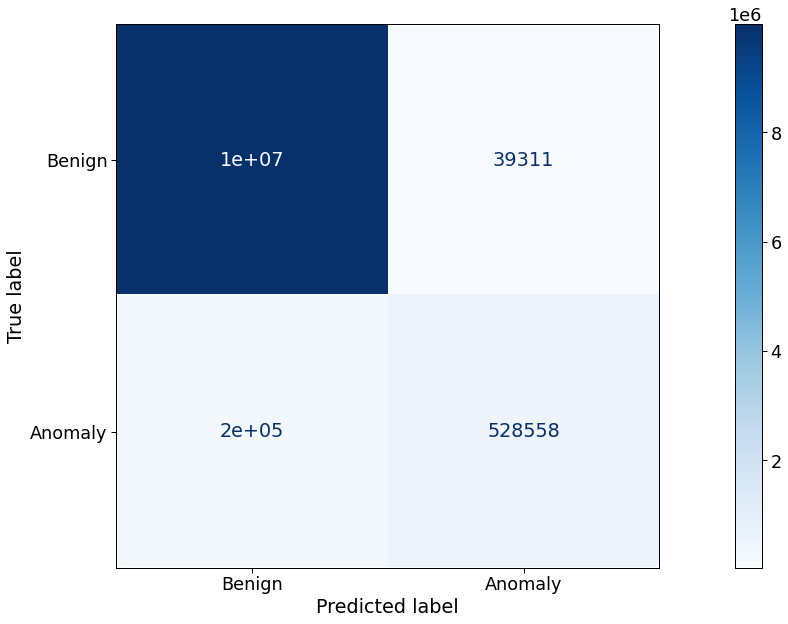

accuracy:  0.9780815872658105
f1:  0.8177942401730408
precision:  0.9307745272237082
recall:  0.7292728491916101
mcc:  0.8131133258331459
attack                    misclassification
Brute Force -Web          0                        26
                          1                      2117
Brute Force -XSS          0                        17
                          1                       910
DoS attacks-GoldenEye     0                     27723
DoS attacks-Hulk          0                    432537
                          1                       111
DoS attacks-SlowHTTPTest  0                     14116
DoS attacks-Slowloris     0                      9512
FTP-BruteForce            0                     25933
Infilteration             0                      2410
                          1                    113951
SQL Injection             1                       432
SSH-Bruteforce            0                     16284
                          1                     78695
dtype: i

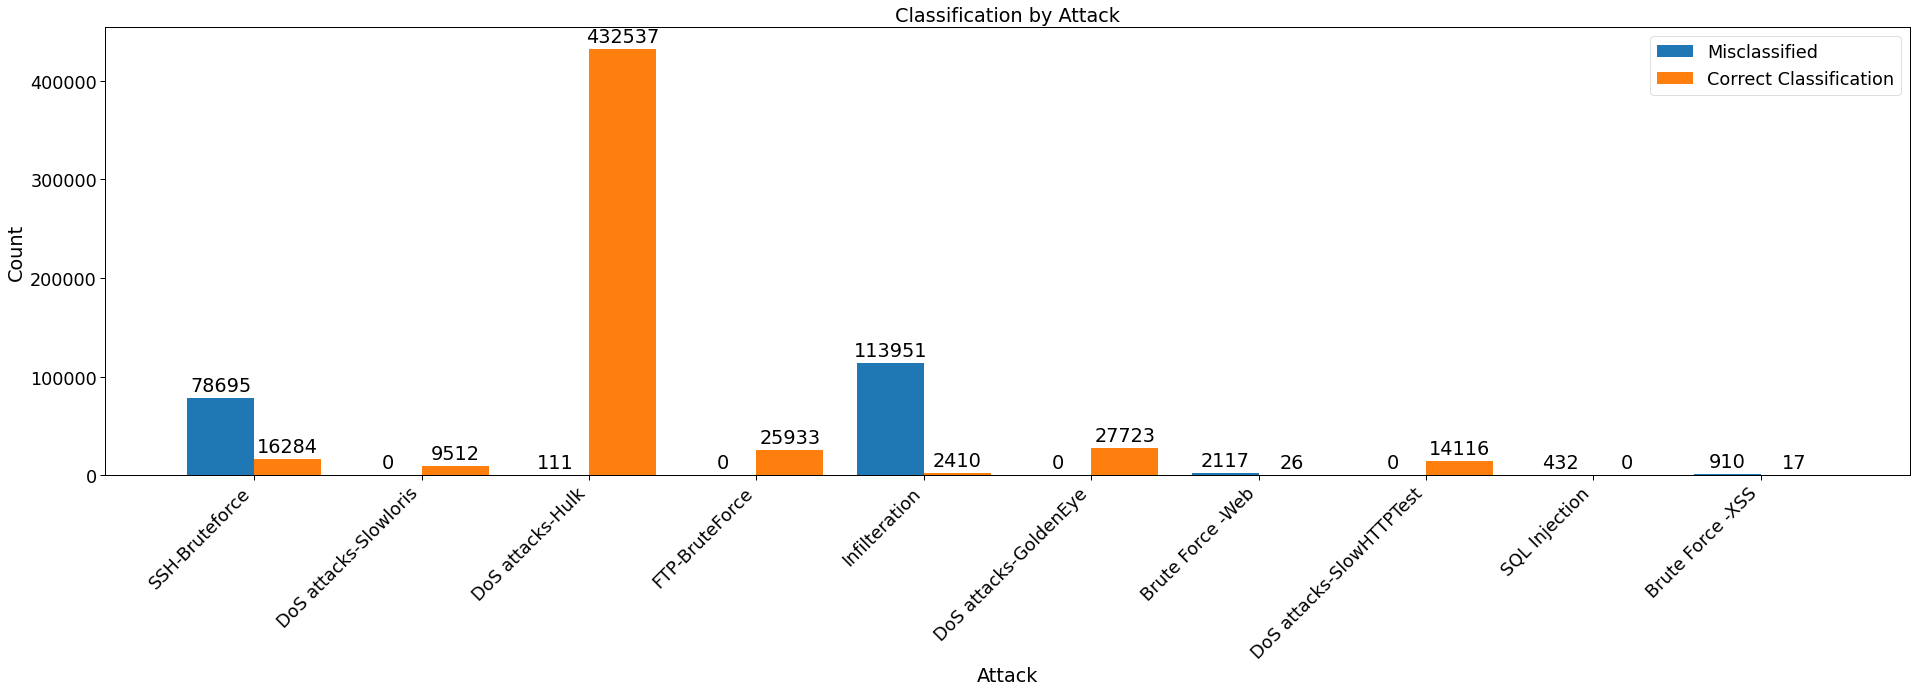

-----------------------------------------


DNN_60_30_oboa.h5 

DNN_60_30_rboa.h5 

OBOA: ROC AUC=0.832
RBOA: ROC AUC=0.941
Random: ROC AUC=0.500


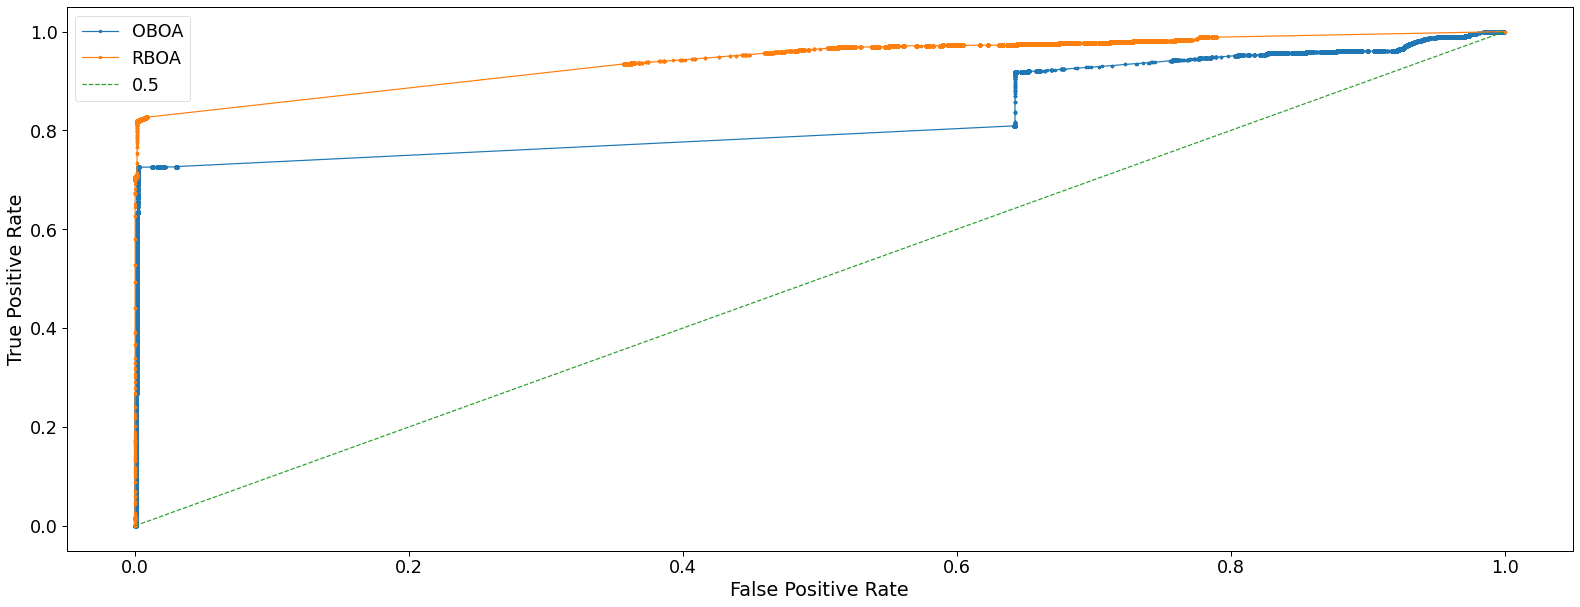

OBOA
[[1415478 8605371]
 [  30165  694609]]


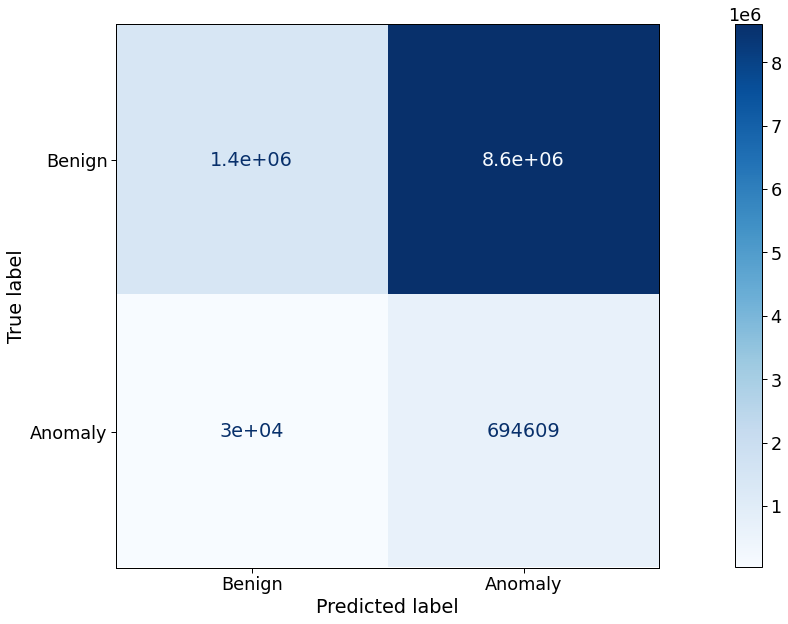

accuracy:  0.1963671161737202
f1:  0.13857876213221787
precision:  0.07468930040709765
recall:  0.9583801295300328
mcc:  0.0732296754774659
attack                    misclassification
Brute Force -Web          0                       310
                          1                      1833
Brute Force -XSS          0                       145
                          1                       782
DoS attacks-GoldenEye     0                     27723
DoS attacks-Hulk          0                    432648
DoS attacks-SlowHTTPTest  0                     14116
DoS attacks-Slowloris     0                      9512
FTP-BruteForce            0                     25933
Infilteration             0                     89183
                          1                     27178
SQL Injection             0                        60
                          1                       372
SSH-Bruteforce            0                     94979
dtype: int64
[94979]
[9512]
[432648]
[25933]
[89183, 27178]


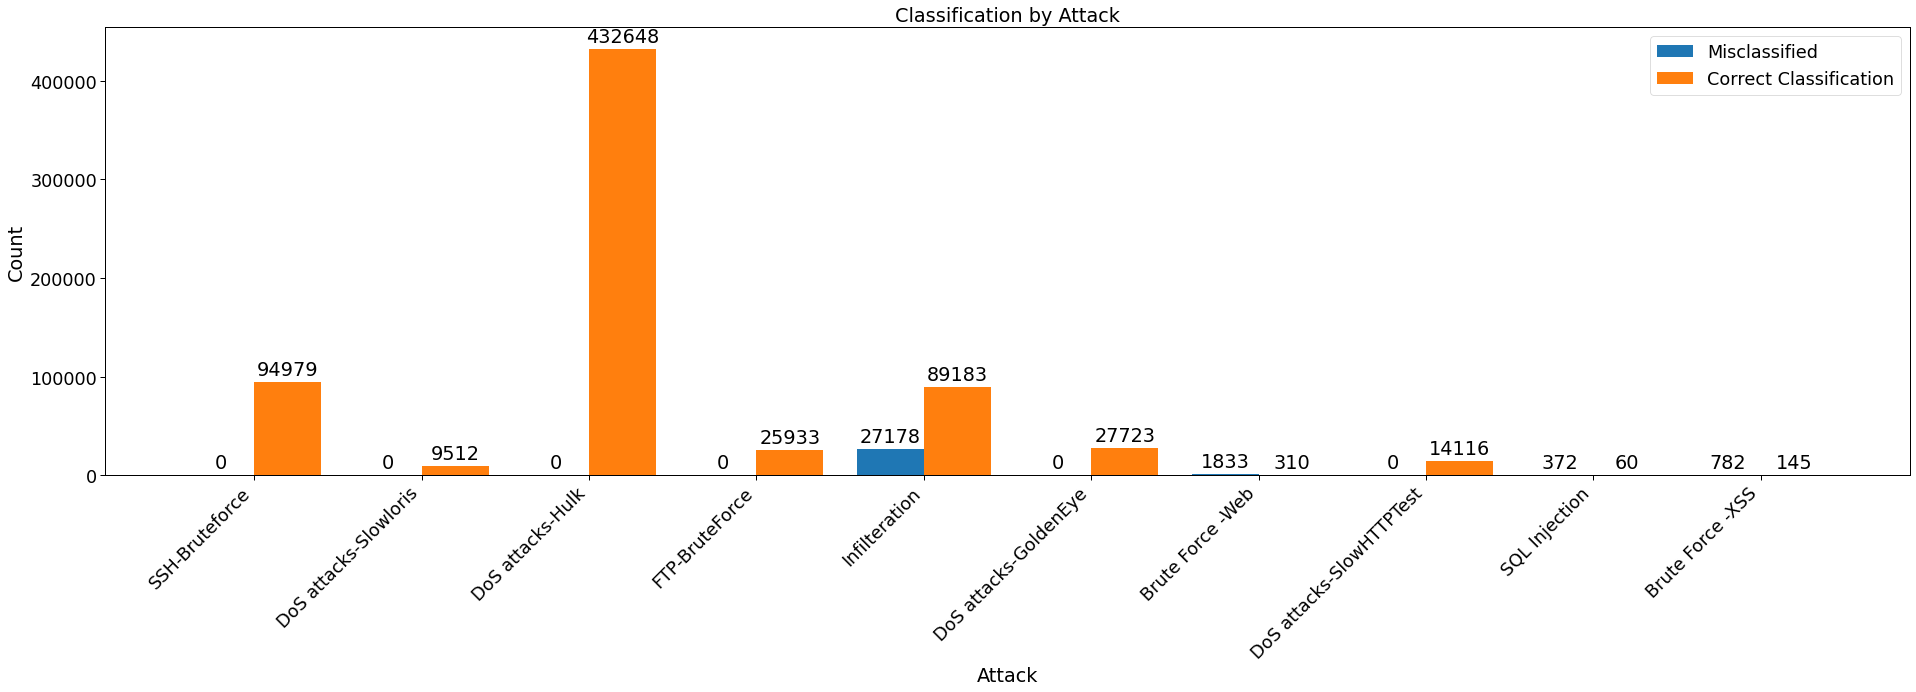

RBOA
[[9951973   68876]
 [ 127332  597442]]


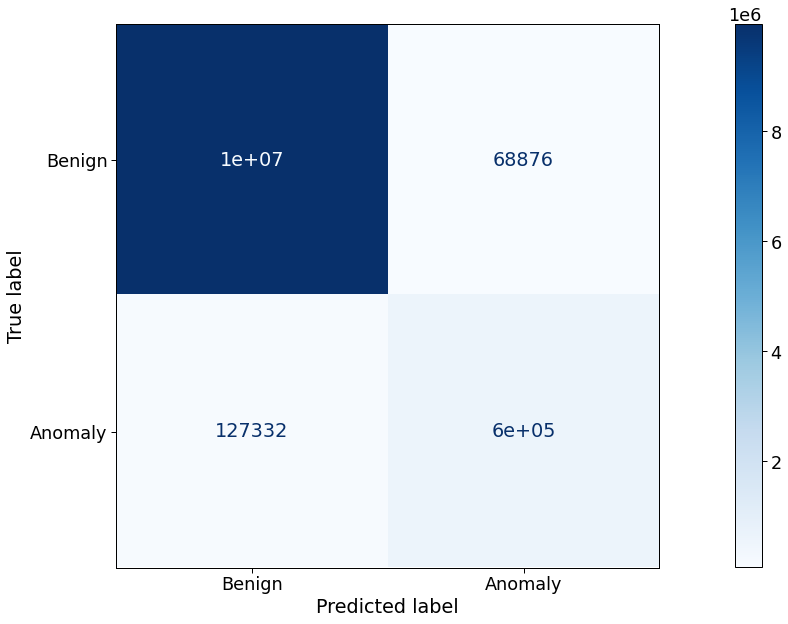

accuracy:  0.9817406584988139
f1:  0.8589539728501063
precision:  0.8966319385038375
recall:  0.8243148898829152
mcc:  0.85006912247629
attack                    misclassification
Brute Force -Web          0                        22
                          1                      2121
Brute Force -XSS          0                        14
                          1                       913
DoS attacks-GoldenEye     0                     27723
DoS attacks-Hulk          0                    432648
DoS attacks-SlowHTTPTest  0                     14116
DoS attacks-Slowloris     0                      9512
FTP-BruteForce            0                     25933
Infilteration             0                      6611
                          1                    109750
SQL Injection             1                       432
SSH-Bruteforce            0                     80863
                          1                     14116
dtype: int64
[80863, 14116]
[9512]
[432648]
[25933]
[6611, 10975

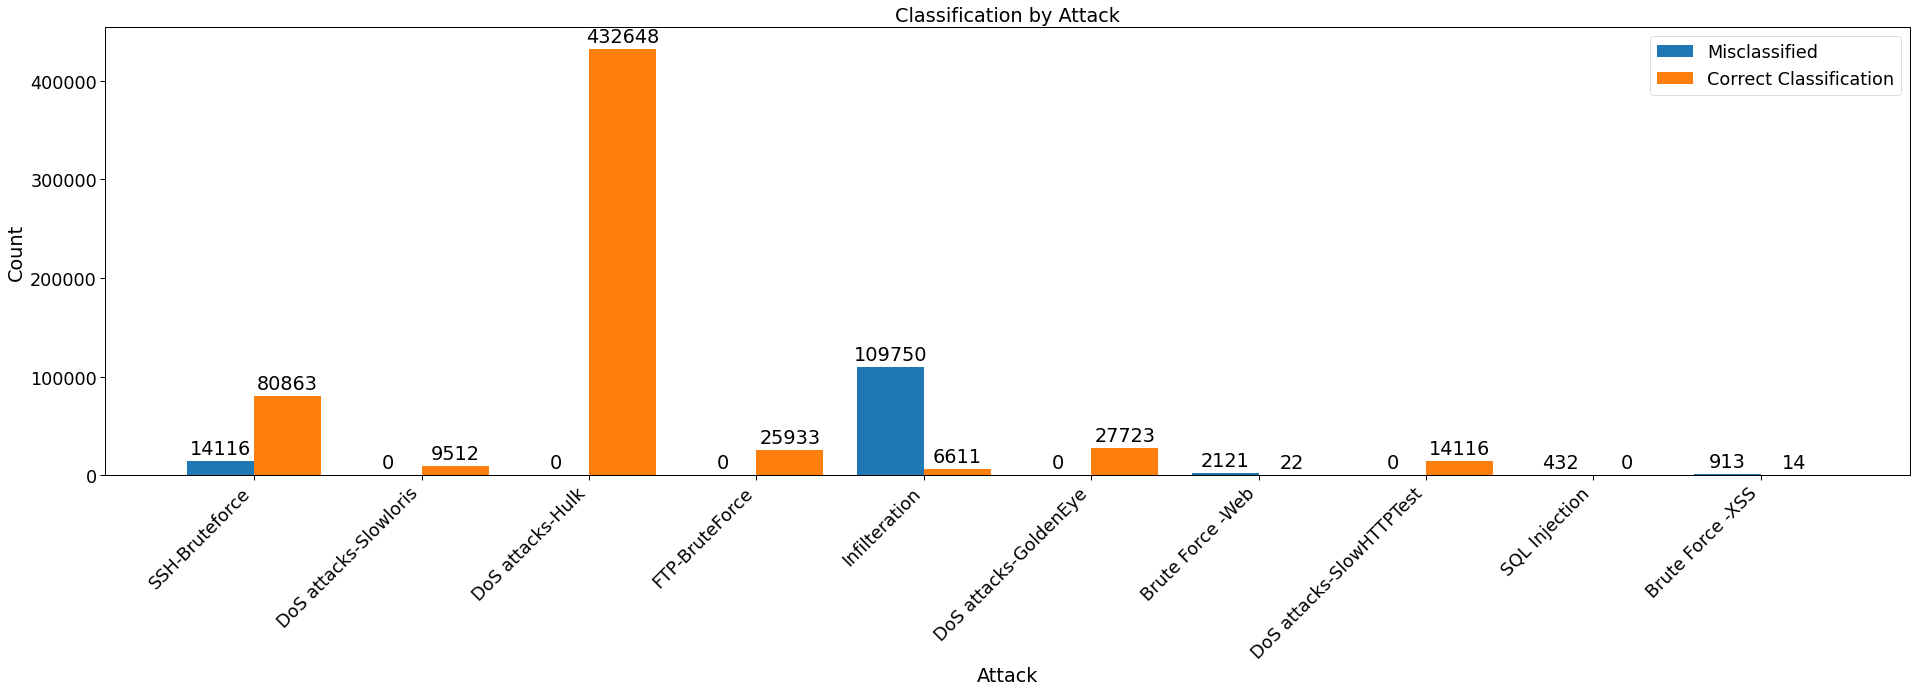

In [7]:
X_1_oboa = np.load(folder_oboa +'X_1_ar.npy')
y_1_oboa = np.load(folder_oboa +'y_1_ar.npy')
a_1_oboa = np.load(folder_oboa +'a_1_ar.npy', allow_pickle=True)

X_1_rboa = np.load(folder_rboa +'X_1_ar.npy')
y_1_rboa = np.load(folder_rboa +'y_1_ar.npy')
a_1_rboa = np.load(folder_rboa +'a_1_ar.npy', allow_pickle=True)

for NN in range(0, len(NNs)):
    print('-----------------------------------------\n\n')
    dnn_file_oboa = "DNN_"+'_'.join(str(v) for v in NNs[NN])+name_tail_oboa+".h5"
    dnn_file_rboa = "DNN_"+'_'.join(str(v) for v in NNs[NN])+name_tail_rboa+".h5"
    
    print(dnn_file_oboa, '\n')
    DNN = load_model(dnnfolder+dnn_file_oboa)
    y_pred_oboa = DNN.predict(X_1_oboa)
    y_predr_oboa = np.rint(y_pred_oboa)
    print(dnn_file_rboa, '\n')
    DNN = load_model(dnnfolder+dnn_file_rboa)
    y_pred_rboa = DNN.predict(X_1_rboa)
    y_predr_rboa = np.rint(y_pred_rboa)
    
    plot_roc_auc(y_1_oboa, y_1_rboa, y_pred_oboa, y_pred_rboa)
    
    print('OBOA')
    test_report(y_1_oboa ,y_predr_oboa)
    attack_report(y_1_oboa, y_predr_oboa, a_1_oboa)
    
    print('RBOA')
    test_report(y_1_rboa ,y_predr_rboa)
    attack_report(y_1_rboa, y_predr_rboa, a_1_rboa)
    
  